#### What qualities contribute to a good recipe? ####
Initially, we must import the necessary libraries to commence the scraping process.

In [7]:

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup  
import pandas as pd
import scipy as sc
import numpy as np
import requests
import re
import time
import csv
from mpl_toolkits.mplot3d import Axes3D
from statistics import LinearRegression
import time

from numpy import average, shape

from matplotlib.widgets import Lasso
import matplotlib.pyplot as plt
import seaborn as sns



#### Scraping ####

Now, as we delve into the scraping process, our first step is to retrieve all the recipe names and corresponding links, saving them to a file for future reference.

In [5]:
def get_full_page_thespruceeats():#this returns a list of all the links to receipies on the page:
    # URL to scrape
    url = "https://www.thespruceeats.com/search?q=&searchType=recipe"

    # Configure the Selenium webdriver
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')  # Run in headless mode (no GUI)
    driver = webdriver.Chrome(options=options)
    driver.get(url)

    # Wait for the page to load
    wait = WebDriverWait(driver, 10)

    # Get the page source and parse it with BeautifulSoup
    page_source = driver.page_source
    soup = BeautifulSoup(page_source, "html.parser")

    results_div = soup.find("div", attrs={"class": "results-list__container"})
    recipe_names = []
    recipe_links = []

    # Scrape the first page
    for li in results_div.find_all("li", class_="results__item"):
        if li.find("a") is not None:
            link = li.find("a").get("href")
        else:
            link = ''

        if li.find("h4", class_="card__title") is not None:
            name = li.find("h4", class_="card__title").text.strip()
        else:
            name = ''
        
        recipe_names.append(name)
        recipe_links.append(link)

    # Scrape subsequent pages if the "Next" button exists
    while True:
        try:
            next_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, ".pagination__item-link--next")))
            next_button.click()
            time.sleep(5)

            # Get the page source and parse it with BeautifulSoup
            page_source = driver.page_source
            soup = BeautifulSoup(page_source, "html.parser")

            results_div = soup.find("div", attrs={"class": "results-list__container"})

            # Scrape recipe names and links
            for li in results_div.find_all("li", class_="results__item"):
                if li.find("a") is not None:
                    link = li.find("a").get("href")
                else:
                    link = ''

                if li.find("h4", class_="card__title") is not None:
                    name = li.find("h4", class_="card__title").text.strip()
                else:
                    name = ''
                print(f"{name} added")
                recipe_names.append(name)
                recipe_links.append(link)

        except:
            break

    # Create a DataFrame with the recipe names and links
    df = pd.DataFrame({"Recipe_name": recipe_names, "Recipe_link": recipe_links})

    # Write DataFrame to a CSV file
    df.to_csv("Recipe_Links_and_Names.csv", index=False)

    # Close the driver
    driver.quit()

    print("Done!")

Let's execute this function! By saving the retrieved data to a CSV file, we can expedite future work, reducing our dependency on the web driver and safeguarding against potential internet interruptions during subsequent tests as well as saving time.

In [ ]:
get_full_page_thespruceeats()

Now that we have obtained the recipe links, our next step is to scrape each individual recipe. To streamline the process, we will break it down into manageable steps. The first step involves creating a "soup" object, which will allow us to parse the HTML content of each recipe page.

In [20]:
data = pd.read_csv("Recipe_Links_and_Names.csv")
data.head()


,Recipe_name,Recipe_link
0,Kentucky Buck Cocktail Recipe,https://www.thespruceeats.com/kentucky-buck-41...
1,Sparkling Borage Cocktail,https://www.thespruceeats.com/sparkling-borage...
2,Lunch Box-Worthy Falafel Kebabs,https://www.thespruceeats.com/falafel-kebabs-r...
3,Chipotle Pumpkin Queso Dip,https://www.thespruceeats.com/chipotle-pumpkin...
4,Flamin' Hot Cheetos Mac and Cheese Bites,https://www.thespruceeats.com/flaming-hot-chee...


In [21]:
def load_soup_object(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            return soup
        else:
            print(f"Error: {response.status_code} - {url}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Error: {e} - {url}")
        return None

Next, we will proceed to gather information in the order it is presented on our site. To ensure efficiency, we will encapsulate the gathering process within functions as we will be looping over them shortly. Our initial function will collect details such as cook time, prep time, total cooking time, and the number of servings.

Extracting this information can be challenging due to the varying formatting across different recipes. Time values can take on various forms, such as "25 min", "2h 15 min", "2 hours 10 min" or numerous other variations. To address this issue, we have implemented a complex regular expression (regex) expression to handle the diverse time formats encountered during scraping.

In [22]:
def get_cook_times(soup_obj):
    lines=[]
    results_items = soup_obj
    results_items = soup_obj.find_all(class_='comp article__decision-block mntl-block')
    if(results_items==[]):
        soup = soup_obj
        results_items = soup.find_all(class_='comp project-meta')        

    for item in results_items:
        item.find_all(class_='meta-text__data')
        for sub_item in item:
            if bool(sub_item.text.strip()):
                clean_text = sub_item.text.strip().replace('\n', '')
                lines.append(clean_text)

    if(len(lines)>1):
        new_string = lines[0] + lines[1]
        lines[0]= new_string

    #use regex expressions to clean up the line we get it looks something like this
    #['Prep: 15 minsCook: 20 minsTotal: 35 minsServings: 6 servingsYield: 1 cake', 'ratingsAdd a comment']
    cook_time_str = re.findall(r'Cook:\s*(?:(\d+)\s*(?:hrs?|hours?)\s*)?(?:(\d+)\s*mins?)?', lines[0])[0]
    prep_time_str = re.findall(r'Prep:\s*(?:(\d+)\s*(?:hrs?|hours?)\s*)?(?:(\d+)\s*mins?)?', lines[0])[0]    
    total_time_str = re.findall(r'Total:\s*(?:(\d+)\s*(?:hrs?|hours?)\s*)?(?:(\d+)\s*mins?)?', lines[0])[0]
    # Convert time to minutes


    hours = int(cook_time_str[0]) if cook_time_str[0] else 0
    minutes = int(cook_time_str[1]) if cook_time_str[1] else 0
    cook_time_minutes = hours * 60 + minutes

    hours = int(prep_time_str[0]) if prep_time_str[0] else 0
    minutes = int(prep_time_str[1]) if prep_time_str[1] else 0
    prep_time_minutes = hours * 60 + minutes


    hours = int(total_time_str[0]) if total_time_str[0] else 0
    minutes = int(total_time_str[1]) if total_time_str[1] else 0
    total_minutes = hours * 60 + minutes
    #sometimes instead of saying servings 6 they say servings 6 to 8 in this case we make it 6
    #example of what text might look like
    #text = "The serving size is 3 servings per container."
    
    if(lines[0].count('serv')):
        match = re.search(r'serv\w*:\D*(\d+)', lines[0], re.IGNORECASE)
        if match:
            servings=(match.group(1))
    else:
        servings=1

    

    # Create a pandas DataFrame from the extracted data
    df = pd.DataFrame({
        'Prep': [prep_time_minutes],
        'Cook': [cook_time_minutes],
        'Total': [total_minutes],
        'Servings': [servings]
    })
    df = df.astype(int)
    return df

Moving on to the second block of information, we will now focus on extracting the dish rating. This part posed its own challenges since the rating is displayed in the form of stars, with increments of 0.5. Instead of a numerical value, we need to determine the count of full stars and half stars to represent the rating.

In [23]:
def get_stars(soup_obj):    
    soup = soup_obj
    results_items = soup.find_all(class_='comp js-feedback-trigger aggregate-star-rating mntl-block')    
    #print(results_items.prettify())
    for item in results_items:##result items size is 1
        text=item.prettify()
        full_stars=text.count('class="active"')
        half_stars=text.count('class="half"')
        return(full_stars+0.5*half_stars)

Up next is extracting the rating count, which doesn't pose any significant challenges. We can straightforwardly gather the number of ratings for each recipe without encountering any notable complexities.

In [24]:
def get_rating_count(soup_obj):
    soup = soup_obj
    rating_elements = soup.find_all("div", attrs={'class': "comp aggregate-star-rating__count mntl-aggregate-rating mntl-text-block"})
    for rating_element in rating_elements:
        rating_text = rating_element.text.strip()
        try:
            num_ratings = int(rating_text.split()[0])
            return num_ratings
        except ValueError:
            pass
    return 0

Moving on to the third block of information, we will now focus on extracting the nutritional values. However, we encountered a particular issue in this step. Alcoholic beverages listed on the site do not provide nutritional values, and unfortunately, there were numerous such recipes.

In [25]:
def get_nutritional_values(soup_obj):
    soup = soup_obj
    results_items = soup.find_all(class_='nutrition-info__table--row')

    nutritional_vals=[]    


    for item in results_items:
        nutritional_vals.append(item.text.strip())
    new_list = []
    for s in nutritional_vals:
        # Split the string by the \n character and add the two parts to a new list
        parts = s.split('\n')
        # Add the new strings to the new list in the desired format
        #[caleories:934,fat:134g,carbs:999]
        new_list.extend([parts[1], parts[0]])
    #[calories,934,far,134g,carbs,1123,]
    df = pd.DataFrame({'nutrient': new_list[::2], 'value': new_list[1::2]})

    # Set 'nutrient' column as index and transpose DataFrame
    df = df.set_index('nutrient').T
    if df.empty: #recepies like cocktails have no calories

        df = pd.DataFrame(columns=['nutrient', 'Calories', 'Fat', 'Carbs', 'Protein'])

        # add a row filled with zeros
        df.loc[0] = ['value', 0, '0g', '0g', '0g']
        df['Calories'] = df['Calories'].astype(np.int32)
        return df 

    df['Calories'] = df['Calories'].astype(int)

    return df

Moving on to the fourth block of relevant information, we will now focus on extracting the list of ingredients. Unfortunately, this step proved to be quite challenging. The class names for some recipes were inconsistent and changed over time, leading to numerous hotfixes and extensive debugging. To address this issue, we introduced a condition to check whether it is the old variant of the site or the new one. In some cases, we were able to filter the ingredients from the beginning if it was the new variant, simplifying future processes to some extent.

In [26]:
def get_ingridients(soup_obj):
    cond=0
    soup = soup_obj
    span_elements = soup.find_all('span', {'data-ingredient-name': 'true'})

    # create an empty list to store the ingredient names
    ingredient_names = []

    # loop over the span elements and extract their text content
    for span in span_elements:
        ingredient_names.append(span.text)
    #print(ingredient_names)
    if(len(ingredient_names)>0):
        return(ingredient_names)
    else:
        cond=0
        soup = soup_obj
        results_items = soup.find_all(class_='structured-ingredients__list text-passage')
                                            #comp ingredient-list simple-list simple-list--bulleted  
        #print(results_items)                                           
        if(results_items==[]): #sometimes they like to change the class name
            soup = soup_obj
            results_items = soup.find_all(class_='simple-list__item js-checkbox-trigger ingredient text-passage')
            cond=1
        nutritional_vals=[]
        if(results_items==[]):
            return []
        
        final_lst=[]

        for item in results_items:    
            nutritional_vals.append(item.text.strip())
            #print(item.text.strip())
        if(cond==1):
            return nutritional_vals
        else:        
            for i in nutritional_vals:
                my_list = [s.strip() for s in i.split('\n\n\n')]
                final_lst.extend(my_list)
                #print(final_lst)
            
            return(final_lst)

Additionally, we wanted to incorporate some additional information based on the ingredients. We examined the ingredients and attempted to determine if they were classified as dairy, meat, fur ("parve"), or a combination of dairy and meat. To identify common meat and dairy products, we conducted online searches and included the first few results as keywords for classification purposes.

In [27]:
def analyze_recipe(ingredients):
    dairy_keywords = ["milk", "cheese", "yogurt", "cream", "butter", "whey", "casein", "curds"]
    meat_keywords = ["beef", "chicken", "pork", "lamb", "turkey", "venison", "duck", "bacon", "sausage",
                     "ham", "prosciutto", "pepperoni", "salami", "chorizo", "bresaola", "pastrami",
                     "corned beef", "veal", "goose", "game", "elk", "bison", "rabbit", "boar", "guinea fowl", "quail"]
    
    categories = {'Dairy': 0, 'Meat': 0, 'Fur': 1}
    
    for ingredient in ingredients:
        ingredient = ingredient.lower()
        if any(keyword in ingredient for keyword in dairy_keywords):
            categories['Dairy'] = 1
            categories['Fur'] = 0
        elif any(keyword in ingredient for keyword in meat_keywords):
            categories['Meat'] = 1
            categories['Fur'] = 0
            
    df = pd.DataFrame(categories, index=[0])
    return df

Now, it's time to merge all the gathered data into a single row of a dataframe. This step will involve looping over the extracted information for each recipe and consolidating it into a unified format. By doing so, we will have a comprehensive dataframe that encapsulates all the relevant details for further analysis.

In [28]:
def merge_fast(url,recepie_name):
    df = pd.DataFrame(columns=['Name','Prep', 'Cook', 'Total', 'Servings', 'Rating','Rating_Count','Dairy','Meat','Fur', 'Calories', 'Fat', 'Carbs', 'Protein', 'Ingredients'])

    soup_obj= load_soup_object(url)

    if soup_obj is not None:
        recipe_df = get_cook_times(soup_obj)

        ratings_list = get_stars(soup_obj)

        nutrition_df = get_nutritional_values(soup_obj)

        ingredients = get_ingridients(soup_obj)

        rating_num = get_rating_count(soup_obj)

        meatdairy_df = analyze_recipe(ingredients)

        if(ingredients==[]):
            ingredients=['','','','']
            print(type(nutrition_df['Calories'][0]))
        new_row = {
            'Name':recepie_name,
            'Prep': recipe_df['Prep'][0],
            'Cook': recipe_df['Cook'][0],
            'Total': recipe_df['Total'][0],
            'Servings': recipe_df['Servings'][0],
            'Rating': ratings_list,
            'Rating_Count':rating_num,
            'Dairy':meatdairy_df['Dairy'][0],
            'Meat':meatdairy_df['Meat'][0],
            'Fur':meatdairy_df['Fur'][0],
            'Calories': nutrition_df['Calories'][0],
            'Fat': nutrition_df['Fat'][0],
            'Carbs': nutrition_df['Carbs'][0],        
            'Protein': nutrition_df['Protein'][0],
            'Ingredients': [ingredients]
        }
        #print(new_row)

        # add the new row to the DataFrame
        df = pd.concat([df, pd.DataFrame(new_row)], ignore_index=True)

        df['Prep'] = df['Prep'].astype(float)
        df['Cook'] = df['Cook'].astype(float)
        df['Total'] = df['Total'].astype(float)
        df['Servings'] = df['Servings'].astype(float)
        df['Rating'] = df['Rating'    ].astype(float)
        df['Calories'] = df['Calories'].astype(float)

    return(df)

Now, we will implement another function that performs the above-mentioned process for each recipe found thus far. As this operation can take some time, we aim to optimize future work by saving the results to a file. This way, we can have the data readily accessible for further analysis.

In [29]:
def fast_scrape(csv_file_name):
    recipe_names = []
    recipe_links = []
    count=0

    with open(csv_file_name, encoding='utf-8', newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip the first row("recipe name,recepie link")
        for row in reader:
            recipe = ','.join(row).strip().replace('\x9c', '')
            last_comma = recipe.rfind(',')
            if last_comma != -1:
                recipe_name = recipe[:last_comma].strip()
                recipe_link = recipe[last_comma + 1:].strip()
                recipe_names.append(recipe_name)
                recipe_links.append(recipe_link)
            else:
                print(f"Invalid row: {row}")

    final_df=pd.DataFrame()
    for name, link in zip(recipe_names, recipe_links):
        # print(f"Recipe name: {name}")
        # print(f"Recipe link: {link}")
        temp_df=merge_fast(link,name)
        temp_df.set_index('Name', inplace=True)  # set the index of temp_df to the recipe name
        if(final_df.empty):
            final_df=temp_df
        else:
            final_df = pd.concat([final_df,temp_df])
        print(final_df)
    #we have some special characters in the ingiridients from time to time forcing us to use utf-8
    final_df.to_csv('my_data.csv', index=True, encoding='utf-8')
    #print(final_df)
    return final_df


In [30]:
fast_scrape('Recipe_Links_and_Names.csv')
data = pd.read_csv('my_data.csv')
data.head()
print("Describe the DataFrame:\n")
data.describe()
df = data
#some of our columns like Fat look like 32g we want to work with numerical values where possible so we remove that g
df['Fat'] = df['Fat'].str.replace(',', '').str.strip().str.rstrip('g').astype(int)
df['Carbs'] = df['Carbs'].str.replace(',', '').str.strip().str.rstrip('g').astype(int)
df['Protein'] = df['Protein'].str.replace(',', '').str.strip().str.rstrip('g').astype(int)

Describe the DataFrame:



#### First Data Analysis ####

Now that we have our dataframe, let's explore and visualize the data to gain insights. To facilitate this process, we will create functions for different types of plots. Specifically, we will implement functions for scatter plots, histograms, and single-column pie charts. These functions will allow us to effectively visualize and analyze the data. Later, we can focus on cleaning and refining the visualizations for a more polished presentation :)

In [31]:
def draw_scatter_2_params(df, col_name_1,col_name_2):
    df.plot.scatter(x=col_name_1, y=col_name_2)

    plt.show()

In [32]:
def draw_histo_1_params(df, col_name):
    # read in your dataframe from a csv file
    # choose the column you want to use for the histogram

    # sort the column values into bins
    bin_values, bin_edges = np.histogram(df[col_name], bins='auto')

    # create the histogram using the sorted bins
    plt.hist(df[col_name], bins=bin_edges)

    # add labels and title to the histogram
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of ' + col_name)

    # display the histogram
    plt.show()


    


In [33]:
def draw_pie_1_params(df,col_name):
    # get the count of unique values in the column
    value_counts = df[col_name].value_counts()

    # create the pie chart
    plt.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%')

    # add title to the pie chart
    plt.title('Pie Chart of ' + col_name)

    # display the pie chart
    plt.show()

In addition to the previously mentioned visualizations, we also want to include a pie chart illustrating the distribution of ingredients. Specifically, we aim to showcase the proportion of recipes that contain meat, dairy, a combination of meat and dairy, and fur ("parve") ingredients. This pie chart will provide a clear overview of the composition of ingredients used in the recipes analyzed.

In [34]:
def draw_pie_meat_dairy_fur(df):    
    # Calculate the number of recipes in each category
    meat_count = len(df[df['Meat'] == 1])
    dairy_count = len(df[df['Dairy'] == 1])
    fur_count = len(df[df['Fur'] == 1])
    dairy_meat_count = len(df[(df['Dairy'] == 1) & (df['Meat'] == 1)])

    # Create a list of category counts and labels
    counts = [meat_count, dairy_count, fur_count, dairy_meat_count]
    labels = ['Meat', 'Dairy', 'Fur', 'Dairy&Meat']

    # Create the pie chart
    plt.pie(counts, labels=labels, autopct='%1.1f%%')

    # Add a title to the chart
    plt.title('Recipe Categories')

    # Show the chart
    plt.show()

Great! We can now proceed to execute the functions for the different types of plots to visualize the data.

In [35]:
def draw_all_histo(df):
    numeric_cols = df.select_dtypes(include=['int', 'float']).columns.to_list()
    # print(df.describe())
    for col in numeric_cols:
        draw_histo_1_params(df,col)

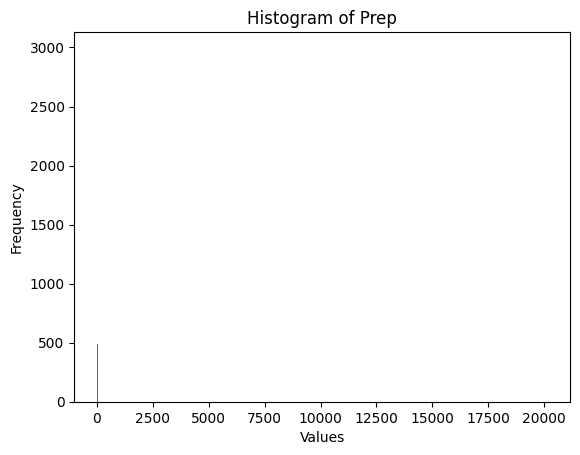

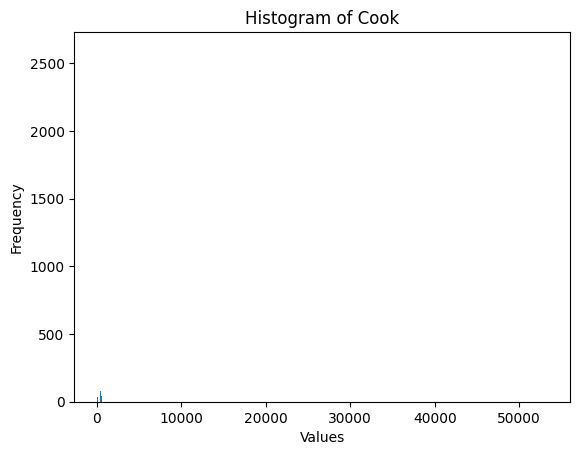

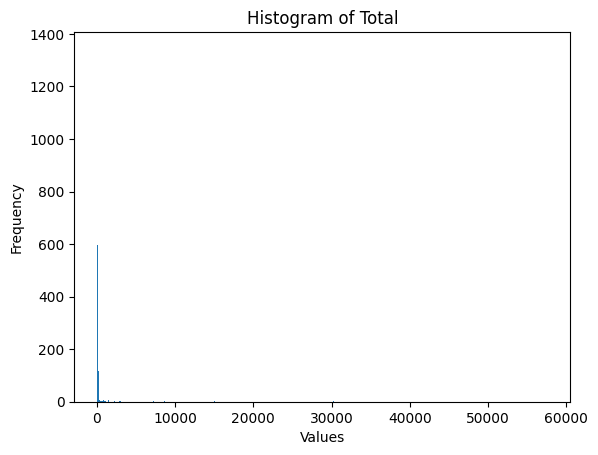

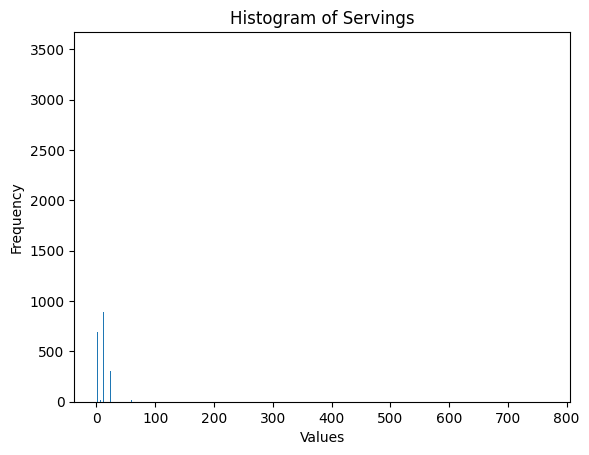

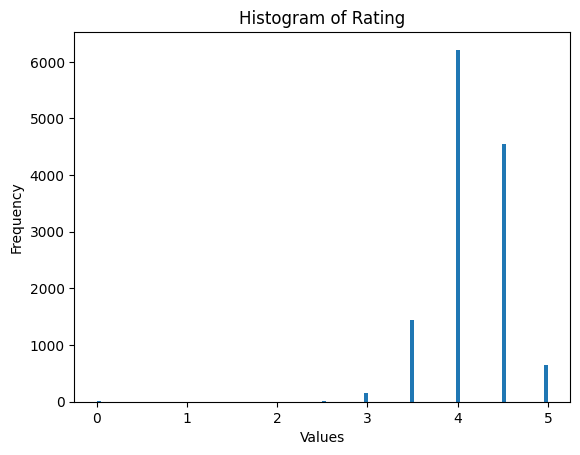

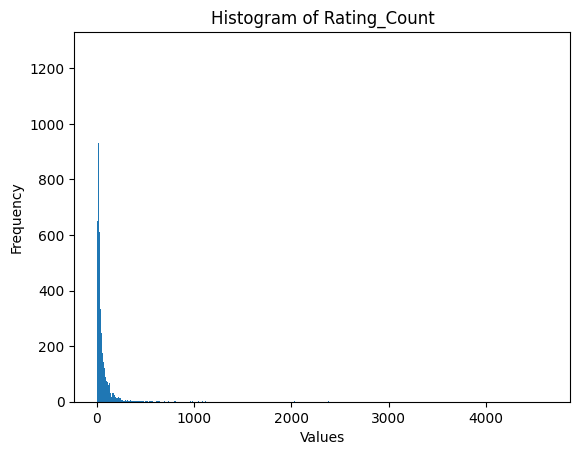

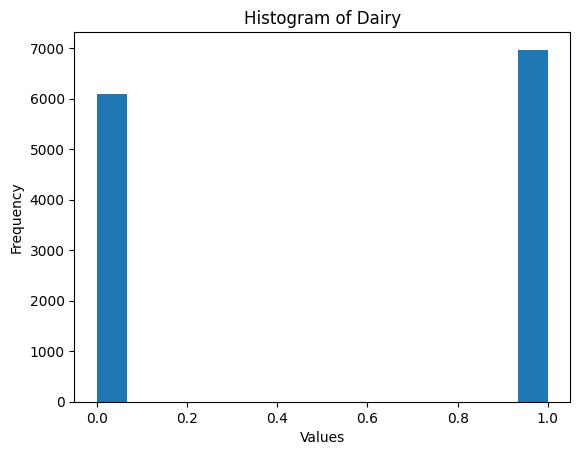

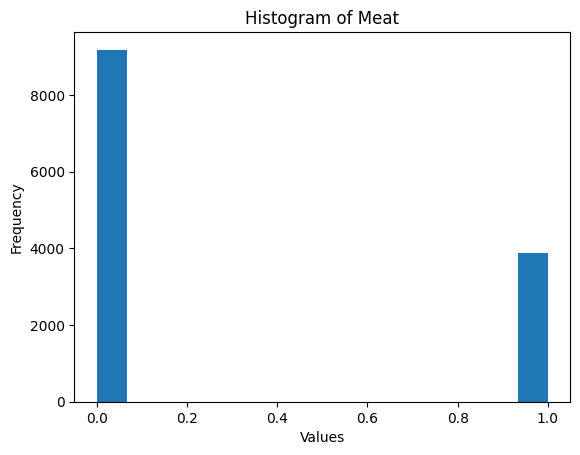

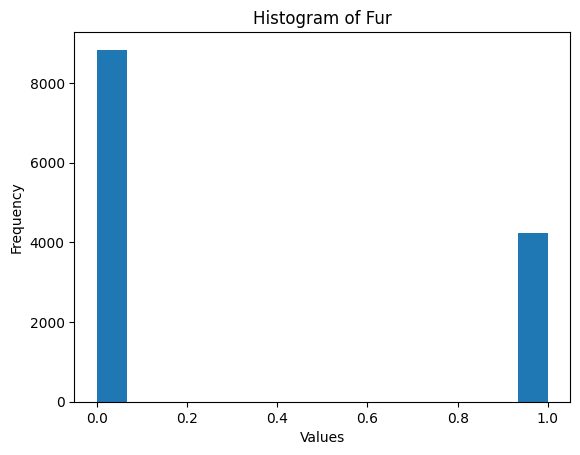

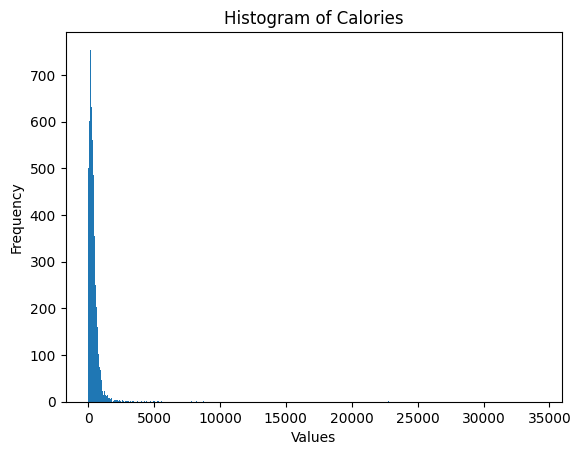

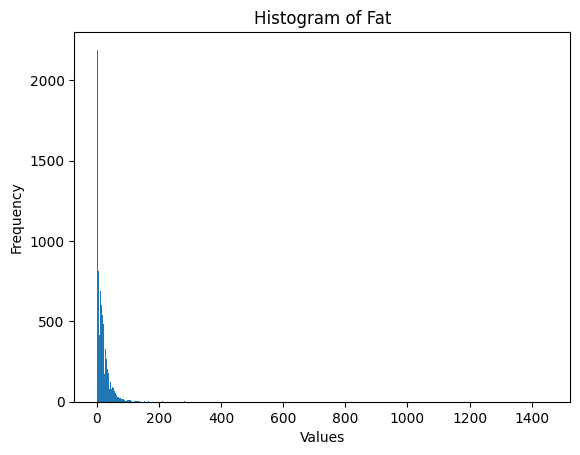

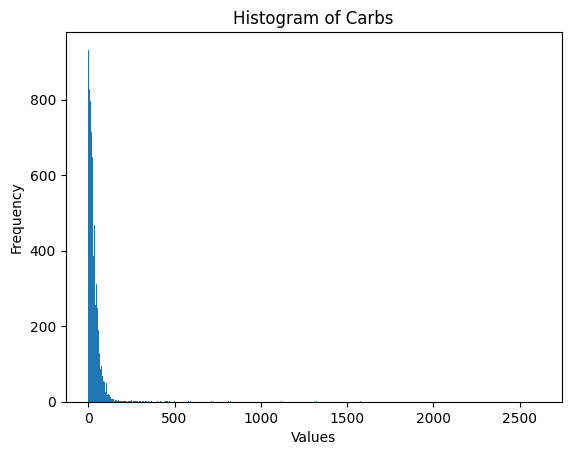

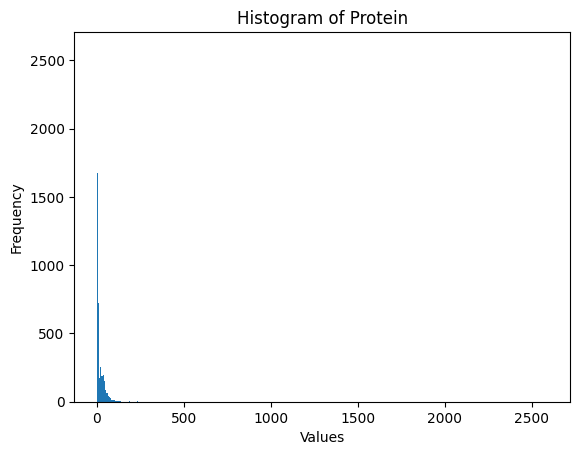

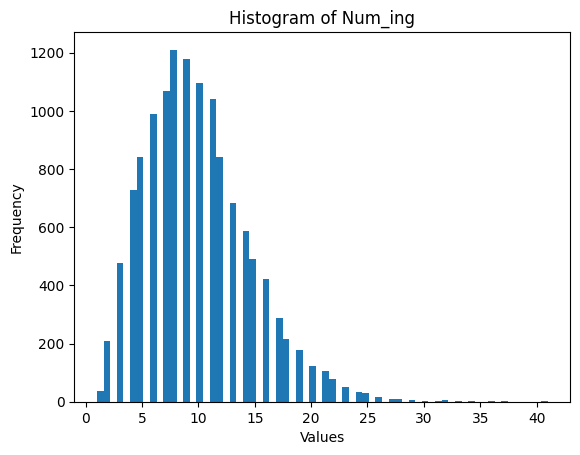

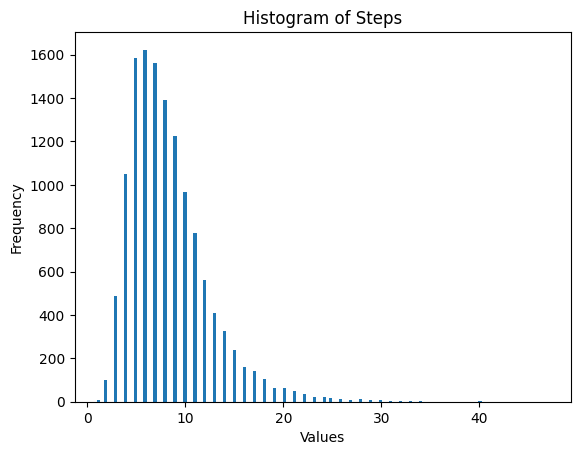

In [36]:
draw_all_histo(df)

Based on the histogram of calories, we can observe that the most common calorie range for recipes is around 180 calories, which is the average value among approximately 700 recipes. Additionally, a significant portion of the recipes falls within the range of 0 to 500 calories.


Similarly, for the histogram of carbohydrates, we observe a similar trend. The average recipe tends to contain carbohydrates within the range of 0 to 50 grams.


#### Cleaning ####

To address the presence of outliers in our data, we will employ a data cleaning approach using the IQR (Interquartile Range) method. By applying this method to the entire dataframe, we can systematically identify and handle outliers across multiple columns. Additionally, we can perform careful adjustments to certain columns. This process will help us clean and prepare the data for further analysis, ensuring more accurate and reliable results.

In [21]:
def clean(df,column_name):
    #print the data we had before so we can later compare
    print(df[column_name].describe())
    # Calculate the IQR of the Prep column
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Determine the upper and lower bounds for the Prep column
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 10 * IQR

    # Replace any values outside of the bounds with NaN
    df.loc[(df[column_name] < lower_bound) | (df[column_name] > upper_bound), column_name] = float('NaN')   
    df.dropna(inplace=True)
    #print the data after cleaning for comparison
    print(df[column_name].describe())
    return df

In our data cleaning process, we will establish a lower boundary of 1.5 times the IQR (Interquartile Range) and an upper boundary of 10 times the IQR. The upper boundary is set relatively high to account for recipes with exceptionally long cooking times, such as those exceeding 8 hours. It is essential to include these legitimate recipes in our analysis. By applying these boundaries, we can identify and handle outliers effectively, ensuring that our cleaned dataset maintains a reasonable range of values while still accounting for the diversity of cooking times present in the recipes.

In [22]:
def clean_df(df):    
    #print(df)
    numeric_cols = df.select_dtypes(include=['int', 'float']).columns
    for col in numeric_cols:
        clean(df,col)

    return df

In [23]:
df = clean_df(df)
df.head()

count    13057.000000
mean        28.052615
std        248.481784
min          0.000000
25%         10.000000
50%         15.000000
75%         20.000000
max      20170.000000
Name: Prep, dtype: float64
count    12869.000000
mean        16.501360
std         14.923245
min          0.000000
25%         10.000000
50%         15.000000
75%         20.000000
max        120.000000
Name: Prep, dtype: float64
count    12869.000000
mean        53.318984
std        548.458014
min          0.000000
25%          7.000000
50%         20.000000
75%         45.000000
max      53400.000000
Name: Cook, dtype: float64
count    12617.000000
mean        37.131251
std         61.402290
min          0.000000
25%          6.000000
50%         20.000000
75%         40.000000
max        420.000000
Name: Cook, dtype: float64
count    12617.000000
mean       211.087897
std       1819.629910
min          0.000000
25%         22.000000
50%         45.000000
75%         85.000000
max      57660.000000
Name: Total,

,Name,Prep,Cook,Total,Servings,Rating,Rating_Count,Dairy,Meat,Fur,Calories,Fat,Carbs,Protein,Ingredients
0,Kentucky Buck Cocktail Recipe,5.0,0.0,5.0,1.0,3.5,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"['1 chopped and muddled strawberry', '1-ounce ..."
1,Sparkling Borage Cocktail,3.0,0.0,483.0,1.0,5.0,6.0,0.0,0.0,1.0,194.0,0.0,19.0,0.0,"['water', 'granulated sugar ', 'borage leaves'..."
2,Lunch Box-Worthy Falafel Kebabs,25.0,30.0,70.0,4.0,4.5,12.0,0.0,0.0,1.0,494.0,17.0,73.0,18.0,"['For the Falafel:', '1 cup canned chickpeas, ..."
3,Chipotle Pumpkin Queso Dip,5.0,4.0,9.0,6.0,5.0,7.0,1.0,0.0,0.0,247.0,17.0,11.0,13.0,"['Velveeta cheese', 'diced tomatoes and green ..."
4,Flamin' Hot Cheetos Mac and Cheese Bites,45.0,25.0,280.0,10.0,4.0,57.0,1.0,0.0,0.0,327.0,21.0,28.0,6.0,"['macaroni and cheese', 'hot sauce', ""Flamin' ..."


After conducting a detailed examination of the data frame, we have identified that certain rows contain incorrect values for "Prep," "Cook," and "Total" time,This issue occurred because of different formats on the site. To rectify this issue, we will implement a simple function to clean the time values for each row. The function will attempt to correct the time values to their appropriate formats whenever possible. However, if a row's time values cannot be corrected, it will be removed from the data frame to ensure data accuracy and consistency. This approach will help us maintain a reliable and clean dataset for further analysis.

In [24]:
def clean_data_time(df):
    #df = pd.read_csv('clean_df.csv')

    # Replace Prep, Cook, and Total values with median if Prep + Cook != Total
    for index, row in df.iterrows():
        if row['Prep'] + row['Cook'] != row['Total']:
            if row['Prep'] != 0:
                df.at[index, 'Cook'] = df.at[index, 'Total'] - df.at[index, 'Prep']
            elif row['Cook'] != 0:
                df.at[index, 'Prep'] = df.at[index, 'Total'] - df.at[index, 'Cook']
            else:
                df.drop(index, inplace=True)

    # Fill missing Total values with Prep + Cook
    df['Total'].fillna(df['Prep'] + df['Cook'], inplace=True)

    # Fill missing Prep or Cook values if only one is missing
    for index, row in df.iterrows():
        if pd.isna(row['Prep']):
            if pd.notna(row['Cook']) and pd.notna(row['Total']):
                df.at[index, 'Prep'] = df.at[index, 'Total'] - df.at[index, 'Cook']
            else:
                df.drop(index, inplace=True)
        elif pd.isna(row['Cook']):
            if pd.notna(row['Prep']) and pd.notna(row['Total']):
                df.at[index, 'Cook'] = df.at[index, 'Total'] - df.at[index, 'Prep']
            else:
                df.drop(index, inplace=True)
        elif pd.isna(row['Total']):
            if pd.notna(row['Prep']) and pd.notna(row['Cook']):
                df.at[index, 'Total'] = df.at[index, 'Prep'] + df.at[index, 'Cook']
            else:
                df.drop(index, inplace=True)

    df = df[(df['Prep'] >= 0) & (df['Cook'] >= 0) & (df['Total'] >= 0)]

    return df

In [25]:
df = clean_data_time(df)
df.head()
df.describe()

,Prep,Cook,Total,Servings,Rating,Rating_Count,Dairy,Meat,Fur,Calories,Fat,Carbs,Protein
count,11814.000000,11814.00000,11814.000000,11814.000000,11814.000000,11814.000000,11814.000000,11814.000000,11814.000000,11814.000000,11814.000000,11814.000000,11814.000000
mean,16.266887,57.54300,73.809887,7.459540,4.174031,44.699170,0.547655,0.294904,0.317166,364.573134,18.094295,32.554427,16.329186
std,15.059619,92.69097,95.778409,7.407628,0.372791,54.327449,0.497745,0.456019,0.465392,294.572239,19.795815,31.194600,21.887940
min,0.000000,0.00000,1.000000,1.000000,3.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,10.00000,20.000000,4.000000,4.000000,14.000000,0.000000,0.000000,0.000000,167.000000,5.000000,12.000000,2.000000
50%,15.000000,25.00000,40.000000,6.000000,4.000000,26.000000,1.000000,0.000000,0.000000,297.000000,13.000000,25.000000,7.000000
75%,20.000000,60.00000,80.000000,8.000000,4.500000,53.000000,1.000000,1.000000,1.000000,479.000000,25.000000,44.000000,23.000000
max,360.000000,690.00000,710.000000,48.000000,5.000000,454.000000,1.000000,1.000000,1.000000,2929.000000,225.000000,339.000000,232.000000


With a clean and corrected data frame, we can now re-evaluate the results and draw meaningful conclusions from the refined data.

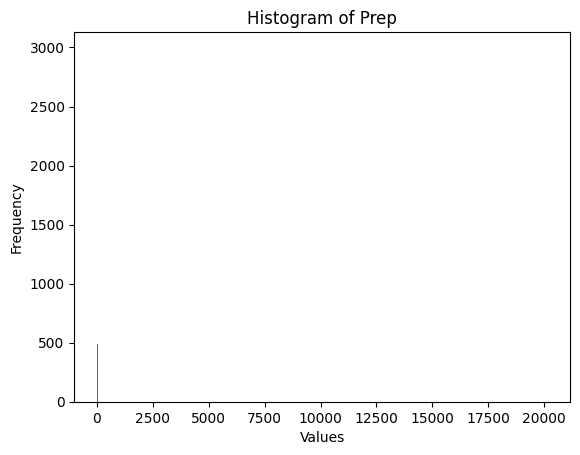

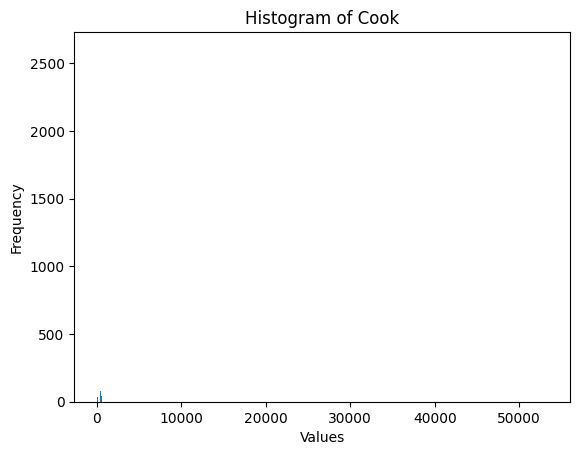

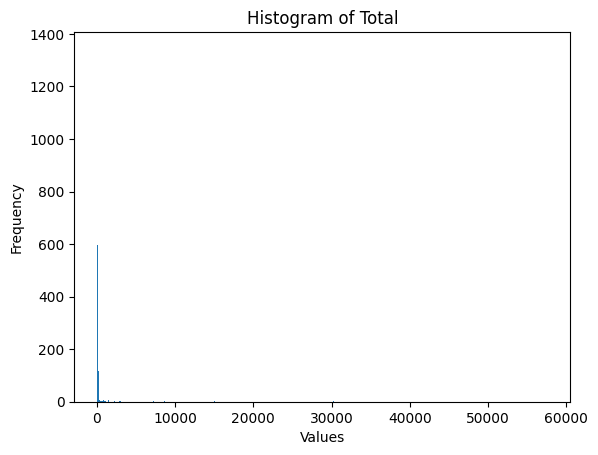

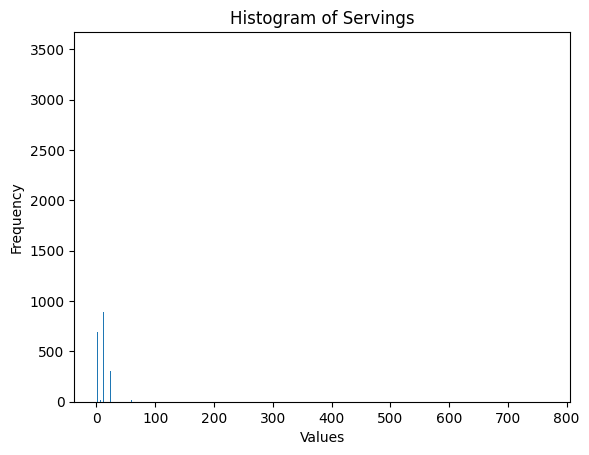

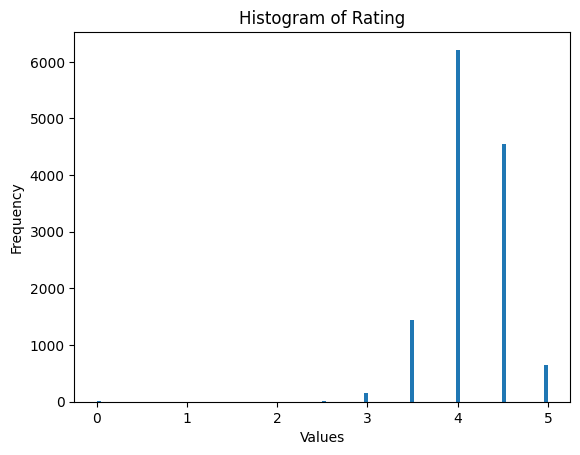

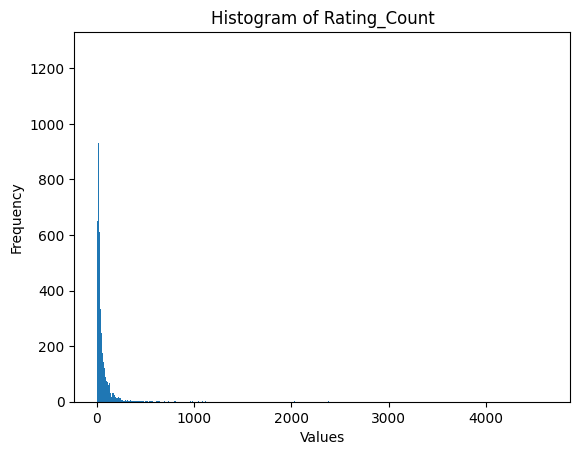

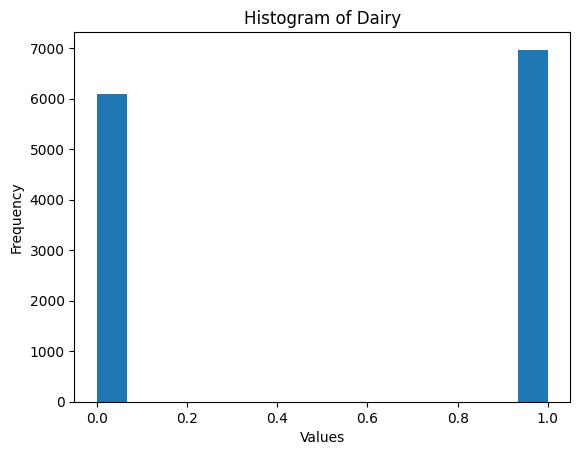

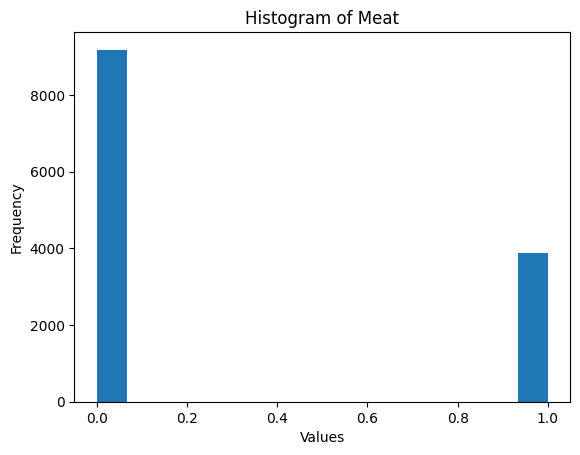

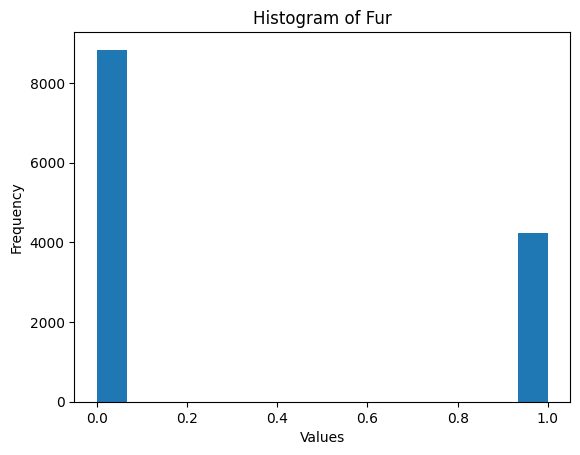

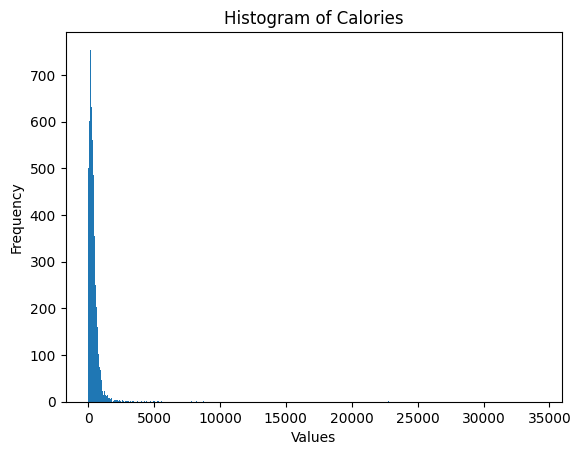

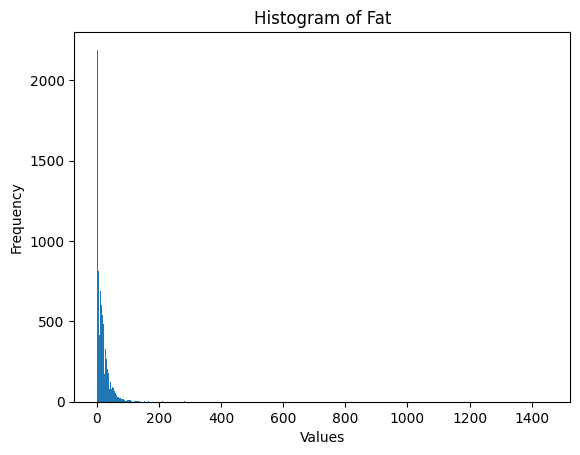

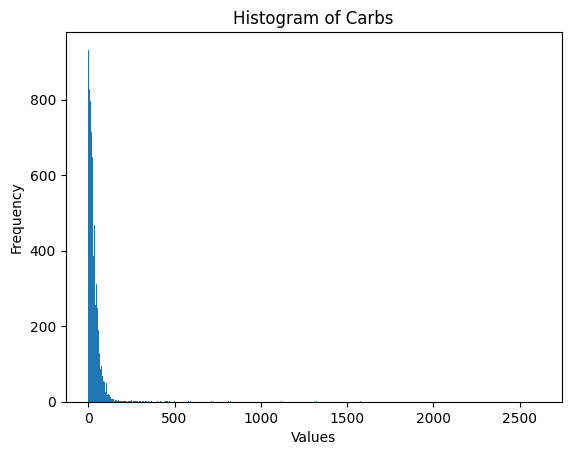

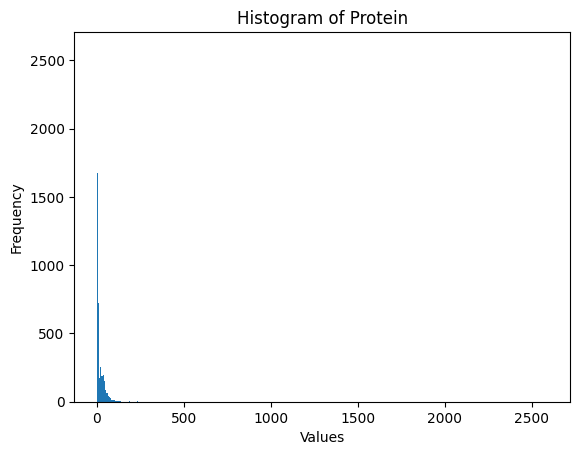

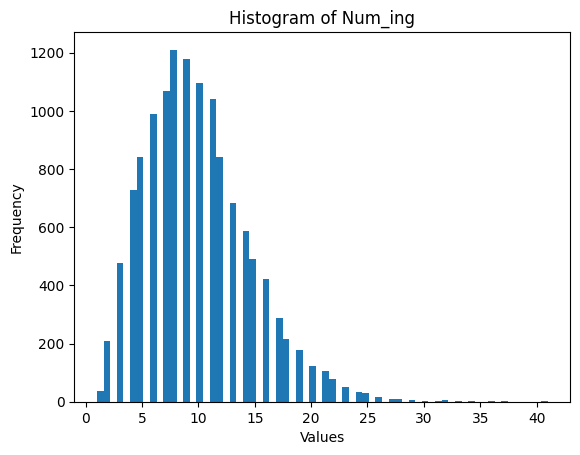

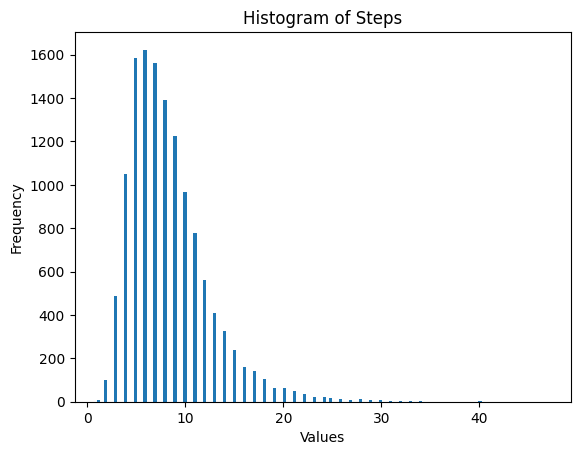

In [37]:
draw_all_histo(df)

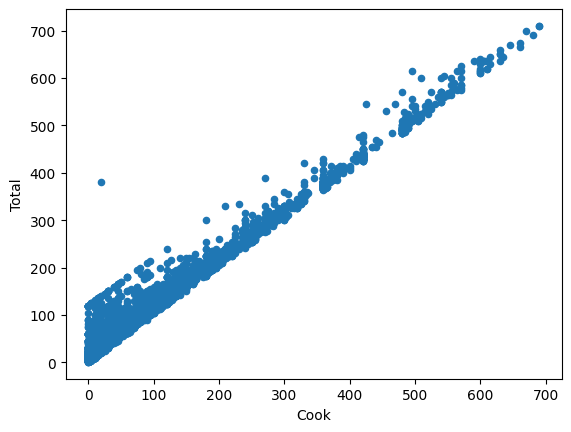

In [26]:
draw_scatter_2_params(df, 'Cook','Total')

From the scatter plot comparing Total Time and Cook Time, we can observe a linear relationship between the two variables. As the Total Time increases, the Cook Time also tends to increase in a consistent manner. This linear correlation indicates that as the overall cooking duration lengthens, the time required for the actual cooking process also extends accordingly. 

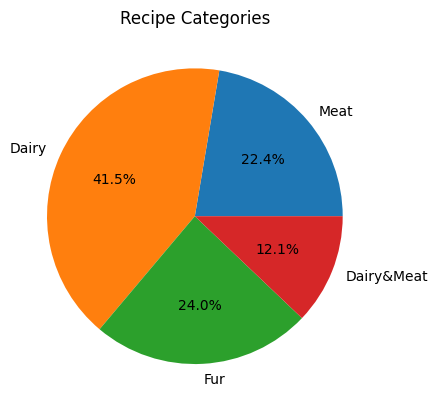

In [27]:
draw_pie_meat_dairy_fur(df)

After analyzing the distribution of ingredients in the cleaned data frame, we can now observe the proportion of recipes falling into different categories: 'Meat', 'Dairy', 'Fur' (parve), and 'Dairy&Meat' (a combination of dairy and meat).

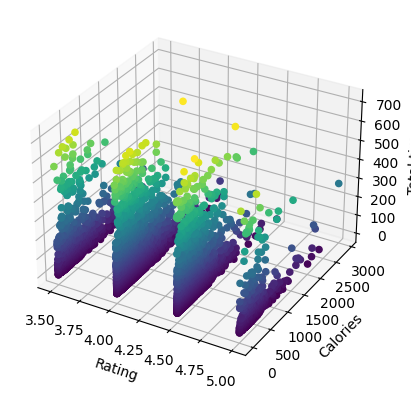

In [28]:
def scatter_3d(df):

    ax = plt.axes(projection='3d')

    xdata = df['Rating']
    ydata = df['Calories']
    zdata = df['Total']

    ax.set_xlabel('Rating')
    ax.set_ylabel('Calories')
    ax.set_zlabel('Total time')

    ax.scatter3D(xdata, ydata, zdata, c=zdata, depthshade=False)
    plt.show()

scatter_3d(df)

Based on the visualization of recipe ratings, we observe that the ratings range from 0 to 5 stars, with increments of 0.5. Additionally, we can examine the distribution of recipes based on their rating, total cooking time, and calorie content. These visualizations help us understand the distribution and relationships between these parameters in our data frame.


#### Finding Correlations :) ####

Moving forward, to determine the correlations between different parameters in our data frame, we will utilize the following approach:

In [29]:
def get_correlation(df, col1, col2):
    return df[col1].corr(df[col2])

Lets run this with each and every column, and print out the ones that have decent correlation 

In [30]:
from statistics import correlation


def get_corr_all_columns(df):    
    numeric_cols = df.select_dtypes(include=['int', 'float'])
    if 'Unnamed' in numeric_cols.columns:
        numeric_cols = numeric_cols.drop('Unnamed', axis=1)

    correlation = {}
    for col1 in numeric_cols:
        for col2 in numeric_cols:
            if col1 != col2:
                corr_value = get_correlation(df, col1, col2)
                if corr_value > 0.5 or corr_value < -0.5:
                    correlation[(col1, col2)] = corr_value

    # Sort the correlations by their absolute value, in descending order
    sorted_correlations = sorted(correlation.items(), key=lambda x: abs(x[1]), reverse=True)

    # Print the correlations above 0.5 or below -0.5
    for corr, value in sorted_correlations:
        if abs(value) > 0.5:
            print(f"{corr[0]} and {corr[1]}: {value}")

To enhance the visualization and facilitate better analysis, we will create two heatmaps based on the correlation matrix:

Heatmap with all the data: This heatmap will display the correlations between all pairs of columns in the data frame. It will provide a comprehensive overview of the relationships among all variables.

Heatmap with strong correlations: This heatmap will focus on displaying only the strong correlations between variables. By setting a threshold for correlation strength (e.g., 0.5 or higher), we can highlight the significant relationships and identify the most influential factors within the dataset.

In [31]:


def draw_heatmap_view(df):
    heat_map_view = df[['Prep', 'Cook', 'Total', 'Servings', 'Rating', 'Rating_Count', 'Dairy', 'Meat', 'Fur', 'Calories','Fat','Carbs','Protein']]
    sns.heatmap(heat_map_view.corr(), annot=True)
    plt.show()

def draw_heatmap_view_important(df):
    heat_map_view = df[['Prep', 'Cook', 'Total', 'Servings', 'Rating', 'Rating_Count', 'Dairy', 'Meat', 'Fur', 'Calories','Fat','Carbs','Protein']]
    corr = heat_map_view.corr()
    mask = (corr > 0.5) | (corr < -0.5)  # set the threshold for correlation values
    sns.heatmap(corr, annot=True, mask=~mask, cmap='coolwarm')
    
    # print the correlations above 0.5 or below -0.5
    print("Correlations above 0.5 or below -0.5:")
    for i in range(len(corr.columns)):
        for j in range(i):
            if mask.iloc[i, j]:
                print(f"{corr.index[i]} - {corr.columns[j]}: {corr.iloc[i, j]}")

    plt.show()

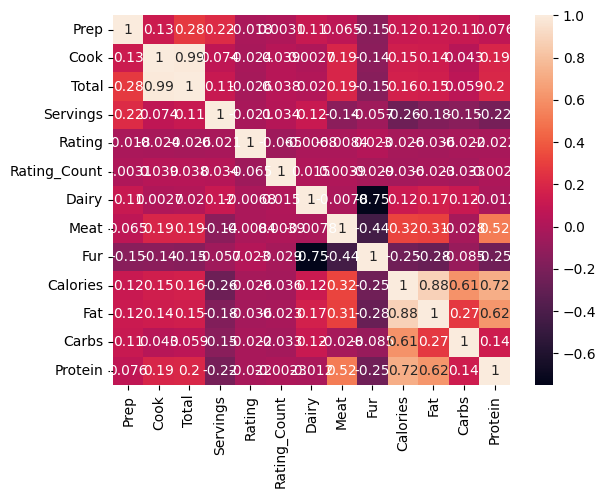

Correlations above 0.5 or below -0.5:
Total - Cook: 0.9877638597640691
Fur - Dairy: -0.7499023829927973
Fat - Calories: 0.8780133880118731
Carbs - Calories: 0.6078798613186035
Protein - Meat: 0.5208843867811936
Protein - Calories: 0.7199358471247601
Protein - Fat: 0.6173507931078869


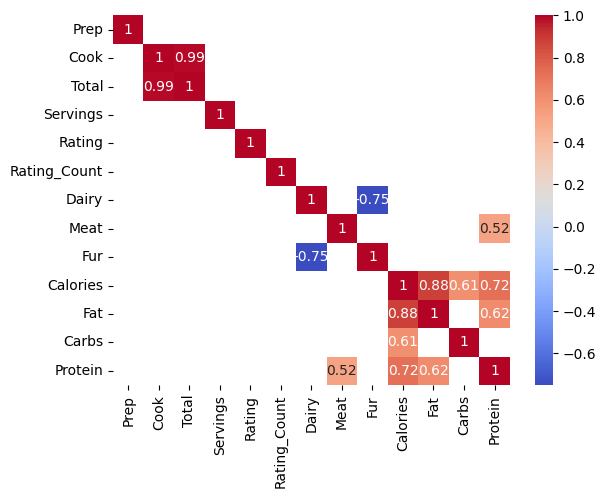

In [32]:
draw_heatmap_view(df)
draw_heatmap_view_important(df)

 It appears that none of the initial parameters we examined in our analysis have a significant correlation with the 'Rating' column. This suggests that the factors we initially considered may not have a direct impact on the recipe rating. While this outcome may be unexpected, lets continue and find out what might affect the Rating.

To determine the factors that contribute to the popularity of a recipe and evaluate the predictability of a recipe's popularity based on these factors, we will begin by filtering the ingredients. Our assumption is that certain ingredients may have a positive or negative impact on the recipe's rating.

With this in mind, we will initiate the cleaning process by applying filters to the ingredients. By categorizing the ingredients based on their potential influence on the recipe's popularity, we can isolate and analyze the impact of specific ingredients or ingredient groups. This approach will help us understand the relationship between ingredients and recipe popularity more effectively.

Let's proceed with the cleaning process and investigate how different ingredients may affect the overall popularity of recipes.

#### Cleaning the Ingredients ####

Lets see what we are working with by using a simple plot to see the most frequent ingredients in the Data Frame.

In [33]:
def initial_data_review(df):
    #Create a list of all the ingredients
    all_ingredients = []

    for i in df['Ingredients']:
        all_ingredients += eval(str(i))
    # Define a list of terms to exclude from the ingredients list
    exclude_terms = ['salt', 'pepper', 'garlic', 'onion', 'paprika', 'cumin', 'chili', 'oregano', 'basil', 'thyme', 'rosemary']
    # Create a list of all the ingredients
    clean_ingredients = []
    for ingredient in all_ingredients:
        ingredient = re.sub(r'\d+(\.\d+)?', '', ingredient) # Remove any quantity
        ingredient = re.sub(r'(\s+\d+)?\s*(large|medium|small)?\s*(cup|teaspoon|tablespoon)s?', '', ingredient, flags=re.IGNORECASE) # Remove any volume/capacity description
        ingredient = ingredient.strip()
        if ingredient and not any(term in ingredient.lower() for term in exclude_terms):
            clean_ingredients.append(ingredient)

    # Count the frequency of each ingredient
    ingredient_counts = pd.Series(clean_ingredients).value_counts()

    # Create a pie chart for the top 10 ingredients
    top_10_ingredients = ingredient_counts.head(10)
    plt.pie(top_10_ingredients, labels=top_10_ingredients.index, autopct='%1.1f%%')
    plt.title('Top 10 Ingredients in Recipes (Excluding Spices)')
    plt.show()

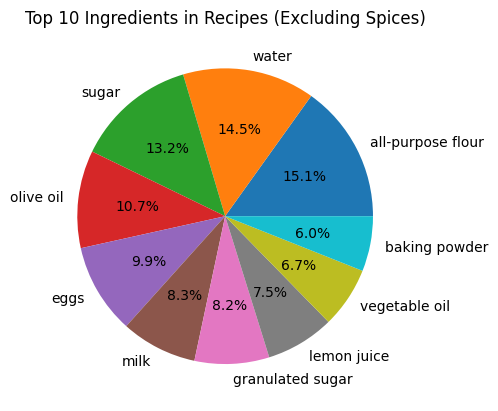

In [34]:
initial_data_review(df)

Although the initial plot of the most frequent ingredients did not provide much insight, it gave us important insight to clean the data as many ingredients had additional information such as volume or weight that we did not need for our analysis. Additionally, there are discrepancies in the ingredient names, such as 'Wheat Flour' and 'Corn Flour' that should both be considered as 'Flour'. This type of data cleaning is crucial to ensure the accuracy and reliability of our analysis.

Our idea was to make a dictionary of the top X ingridients and manully filter the junk out of them first lets make a dictionary with the most common words

In [35]:
import collections

def find_most_common_ingridients(df):
    final_lst = []
    ingredients = df['Ingredients'].tolist()

    for item in ingredients:
        temp = item.replace("'", "")   
        temp = item.replace("\\\\xa0", " ")
        temp = item.replace("\\\\u200b", " ")
        temp = temp.strip("[]").split(", ")
        temp_tokens = []
        for item in temp:
            temp_tokens.extend(item.split())
        final_lst.extend(temp_tokens)

    #print(final_lst)
    word_count = collections.Counter(final_lst)

    # Filter out items that start with a digit(1 cup of ___)
    sorted_dict = {k: v for k, v in word_count.items() if not k[0].isdigit()}
    sorted_dict = dict(sorted(sorted_dict.items(), key=lambda x: x[1], reverse=True))
    print('\n\n\n\n')

    # Create a DataFrame from the sorted dictionary and save it as a CSV file
    df = pd.DataFrame.from_dict(sorted_dict, orient='index', columns=['count'])
    df.to_csv('Ingredients_dirty.csv')
    
    for i, (key, value) in enumerate(sorted_dict.items()):
        if i == 300:
            break
        print(f"{key}: {value}")
    return sorted_dict

To streamline the data cleaning process, we utilized the power of text editors like Notepad++ and applied regular expressions (regex) to manipulate the ingredient data. Here are the steps we followed:

Lowercasing: We converted all the ingredient names to lowercase to ensure consistency and eliminate any case-related discrepancies.

Removing cells with numbers: Since we wanted to focus on ingredient names rather than quantities or measurements, we removed any cells that contained numbers.

Removing duplicates: We eliminated duplicate ingredient entries to avoid redundancy in our analysis.

Clustering similar ingredients: We manually reviewed the ingredient list and grouped together ingredients that were essentially the same but had slight variations in their names. For example, 'Wheat Flour' and 'Corn Flour' were clustered as 'Flour' since they both belong to the same category.

These manual steps were necessary due to the complexity and variations in ingredient names. By carefully curating and organizing the ingredient data, we can now proceed with a cleaner and more consistent dataset for further analysis.

We ended up with a list of roughly 225 ingridients the final file looked something like this

worcestershire sauce,coconut milk sauce,lemon butter sauce,apple cider syrup,green curry sauce,strawberry sauce,chocolate syrup,bok choy leaves,chocolate cream,bearnaise sauce,cilantro leaves,vanilla extract,condensed milk,tzatziki sauce,teriyaki sauce,almond extract,barbecue sauce..... etc.


Now that we have defined our set of relevant ingredients, it is time to filter the original ingredient data. Our goal is to replace any ingredient that appears as a substring in the original ingredients column with the corresponding ingredient name from the new CSV file.

In [36]:
def read_ingridients():
    with open('ingridients.csv', 'r') as file:
    # Initialize an empty list to store the data
        data = []
        for line in file:
            line = line.strip()
            values = line.split(',')
            return values
    return data

In [37]:
def delete_index_columns(df):
    # Get a list of all column names that start with 'Unnamed'
    index_cols = [col for col in df.columns if col.startswith('Unnamed')]
    df.drop(columns=index_cols, inplace=True)
    
    return df

During the data cleaning process, we observed that the word 'tea' appeared frequently in the ingredient lists. This occurrence was a result of the word 'Teaspoon' being transformed to 'tea' after applying our clean_ingredients function. To address this issue and ensure accurate representation, we decided to clean the ingredient lists by removing the term 'Teaspoon' from the ingredients before proceeding as we planed.

In [38]:
def remove_teaspoon(df, column):  
  df[column] = df[column].str.replace('teaspoon', '')
  df=delete_index_columns(df)
  return df

In [39]:
def clean_ingridients(df):
    df2=df.copy()
    pure_ingredients=read_ingridients()
    print("starting ingridient cleanup this might take a minute")
    #df=pd.read_csv(filename)
    for i, ingredient in enumerate(df2['Ingredients']):
        line = ingredient.split(",")
        for j, item in enumerate(line):
            for single_ingredient in pure_ingredients:
                if single_ingredient.lower() in item.lower():
                    #print(f'found {single_ingredient} in {item}')
                    line[j] = single_ingredient.lower()
        df2.loc[i, 'Ingredients'] = ",".join(line)
        #print(line)
        #print('\n\n')
    #print(df['Ingredients'])
    # save the modified dataframe to a new CSV file
    df2=delete_index_columns(df)
    #df2.to_csv('clean_modified.csv', index=False)
    print("done!")
   
    return df2

In [40]:
df = remove_teaspoon(df,'Ingredients')# Removing the teaspoon word from the list of ingredients
df = clean_ingridients(df)# Cleaning the data by ingredients

C:\Users\danie\AppData\Local\Temp\ipykernel_1224\3389712600.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].str.replace('teaspoon', '')
C:\Users\danie\AppData\Local\Temp\ipykernel_1224\652683192.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=index_cols, inplace=True)


starting ingridient cleanup this might take a minute
done!


C:\Users\danie\AppData\Local\Temp\ipykernel_1224\652683192.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=index_cols, inplace=True)


Lets visualise this and hope that we cleaned it properly. We can now see what are the most frequent ingredients:

In [41]:
def get_ingridients_dict(df):
    ingredients = []

    with open('ingridients.csv', newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            ingredients.extend(row)

    ingredients_dict = {}

    # loop through the ingredients in the DataFrame
    for line in df['Ingredients']:
        for single_item in line.split(','): # split the ingredients by comma if they're in a single string
            for ing_in_lst in ingredients: # loop through the ingredients in the ingredients list
                if ing_in_lst in single_item.strip(): # check if the ingredient in the list is a substring of the ingredient in the dataset
                    # if the ingredient exists in the dictionary, increment its count
                    if ing_in_lst in ingredients_dict:
                        ingredients_dict[ing_in_lst] += 1
                    # otherwise, add the ingredient to the dictionary with a count of 1
                    else:
                        ingredients_dict[ing_in_lst] = 1

    # sort the dictionary by value in descending order
    sorted_dict = dict(sorted(ingredients_dict.items(), key=lambda x: x[1], reverse=True))

    #print the dictionary of ingredients and their counts
    print("Printing the ingredient Counts:")
    for ing, count in sorted_dict.items():
        print(f'{ing}: {count}')   
    return sorted_dict

In [42]:
Sorted_dict = get_ingridients_dict(df)
print("Printing the ingredient Counts:")
for ing, count in Sorted_dict.items():
  print(f'{ing}: {count}')   


Printing the ingredient Counts:
salt: 10081
pepper: 6712
sugar: 5872
oil: 4878
butter: 4685
onion: 3982
egg: 3709
garlic: 3528
flour: 3467
water: 2852
milk: 2792
juice: 2543
cream: 2443
olive: 2428
cheese: 2405
lemon: 2241
nut: 2007
vanilla: 1989
chicken: 1796
tomato: 1646
vanilla extract: 1560
vegetable: 1558
corn: 1417
parsley: 1178
cinnamon: 1174
vinegar: 1070
beef: 1042
bread: 964
apple: 947
rice: 944
potato: 929
baking powder: 920
ginger: 898
wine: 895
lime: 858
chocolate: 826
broth: 803
soy sauce: 799
mustard: 774
potatoe: 757
celery: 749
carrot: 748
orange: 745
chili: 712
soda: 711
cumin: 683
mushroom: 640
thyme: 630
seeds: 622
coconut: 599
stock: 568
baking soda: 561
paprika: 541
garlic powder: 540
cilantro: 536
nutmeg: 534
pork: 523
cornstarch: 517
honey: 512
nuts: 497
beans: 486
basil: 482
chile: 473
cheddar: 473
liqueur: 470
cayenne: 463
sour cream: 453
oregano: 452
almond: 436
breadcrumbs: 433
pie: 424
sesame: 409
bacon: 406
chips: 402
mayonnaise: 402
mayonnais: 402
yeast: 

Printing the ingredient Counts:
salt: 10081
pepper: 6712
sugar: 5872
oil: 4878
butter: 4685
onion: 3982
egg: 3709
garlic: 3528
flour: 3467
water: 2852
milk: 2792
juice: 2543
cream: 2443
olive: 2428
cheese: 2405
lemon: 2241
nut: 2007
vanilla: 1989
chicken: 1796
tomato: 1646
vanilla extract: 1560
vegetable: 1558
corn: 1417
parsley: 1178
cinnamon: 1174
vinegar: 1070
beef: 1042
bread: 964
apple: 947
rice: 944
potato: 929
baking powder: 920
ginger: 898
wine: 895
lime: 858
chocolate: 826
broth: 803
soy sauce: 799
mustard: 774
potatoe: 757
celery: 749
carrot: 748
orange: 745
chili: 712
soda: 711
cumin: 683
mushroom: 640
thyme: 630
seeds: 622
coconut: 599
stock: 568
baking soda: 561
paprika: 541
garlic powder: 540
cilantro: 536
nutmeg: 534
pork: 523
cornstarch: 517
honey: 512
nuts: 497
beans: 486
basil: 482
chile: 473
cheddar: 473
liqueur: 470
cayenne: 463
sour cream: 453
oregano: 452
almond: 436
breadcrumbs: 433
pie: 424
sesame: 409
bacon: 406
chips: 402
mayonnaise: 402
mayonnais: 402
yeast: 

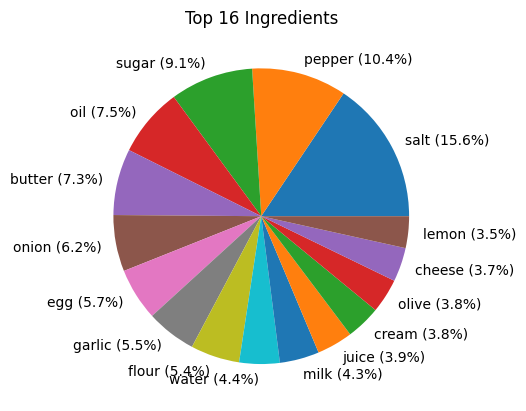

In [43]:
def draw_ingridient_pie_chart(df,top_n):
    # print()
    ingredient_counts = get_ingridients_dict(df)

    # Extract the top N ingredients by frequency
    ingredient_names = collections.Counter(ingredient_counts).most_common(top_n)
    ingredient_names = [x[0] for x in ingredient_names]
    ingredient_frequencies = [ingredient_counts[name] for name in ingredient_names]
    total_receipe_count = sum(ingredient_frequencies)
    ingredient_percentages = [(count/total_receipe_count)*100 for count in ingredient_frequencies]
    ingredient_labels = ['{} ({:.1f}%)'.format(name, percentage) for name, percentage in zip(ingredient_names, ingredient_percentages)]

    # Create the pie chart
    plt.pie(ingredient_percentages, labels=ingredient_labels)
    plt.title('Top {} Ingredients'.format(top_n))
    plt.show()

draw_ingridient_pie_chart(df,16)

looks like it works properly :)

To explore the potential correlation between ingredients and recipe ratings, we employed a technique called "ingredient explosion." This technique involves expanding the ingredients into binary columns, where a value of 1 indicates the presence of an ingredient in a recipe, and 0 indicates its absence.

By utilizing this approach, we can transform the ingredient data into a more structured format that allows us to analyze the relationship between individual ingredients and recipe ratings. The binary columns provide a way to quantify the presence or absence of specific ingredients for each recipe in the dataset.

With the exploded ingredient columns in place, we can proceed with investigating the correlation between these ingredient indicators and the recipe ratings to gain insights into which ingredients may have an impact on the overall rating.

In [44]:
def explode_ingridients_and_get_corr(df):#this function expands the dataframe to each ingridient and tries to find a correlation
    #df = pd.read_csv('clean_modified.csv')

    # extract the ingredients column
    df_ing = df['Ingredients']

    # define a list of ingredients you care about
    important_ingredients = []

    with open('ingridients.csv', newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            important_ingredients.extend(row)

    # loop through the ingredients you care about
    for ingredient in important_ingredients:
        # create a new column with a value of 1 if the recipe contains the ingredient and 0 otherwise
        df[ingredient] = df_ing.str.contains(ingredient).astype(int)

    correlations = df[['Rating'] + [ingredient for ingredient in important_ingredients]].corr()

    # print the correlation coefficients for each ingredient
    # print(correlations.loc['Rating'])
    top_20 = correlations.loc['Rating'].sort_values(ascending=False)[1:21]
    print("Top 20 ingredients with the highest correlation with the 'Rating' column:")
    print(top_20)
    return df

In [45]:
df= explode_ingridients_and_get_corr(df)

C:\Users\danie\AppData\Local\Temp\ipykernel_1224\1978579149.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ingredient] = df_ing.str.contains(ingredient).astype(int)
C:\Users\danie\AppData\Local\Temp\ipykernel_1224\1978579149.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ingredient] = df_ing.str.contains(ingredient).astype(int)
C:\Users\danie\AppData\Local\Temp\ipykernel_1224\1978579149.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

Top 20 ingredients with the highest correlation with the 'Rating' column:
liqueur       0.062360
juice         0.056769
olive         0.044955
vodka         0.044154
orange        0.039164
apple         0.033292
lemon         0.030181
cheese        0.029343
bacon         0.028237
pepper        0.025770
mayonnaise    0.024706
mayonnais     0.024706
pecan         0.023676
sage          0.023397
pineapple     0.023266
walnut        0.023119
pear          0.023077
sour cream    0.022363
beer          0.021940
beans         0.021857
Name: Rating, dtype: float64


#### Machine Learning ####

After conducting an in-depth analysis, we discovered that there are no significant correlations between individual ingredients and recipe ratings. This finding provides an answer to one of our research questions, indicating that no specific ingredient can directly predict the rating of a recipe.

This outcome emphasizes the complexity of determining what makes a recipe highly rated and underscores the importance of considering various factors such as preparation methods, cooking techniques, flavor combinations, and presentation when evaluating recipe quality.

The natural next step is to try machine learning, and see if it can predict the rating and if it can, check its weights and draw conclusions from there.

Lets first import our relevent lybraries:

In [6]:
from sklearn.linear_model import Perceptron
from sklearn.metrics  import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler

In [47]:
def predict_rating_linear(df):
    # Prepare X and y
    X = df.drop(['Ingredients', 'Name', 'Rating'], axis=1)
    y = df['Rating']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and fit the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Round predicted ratings to nearest half-integer value
    def round_half_up(x):
        # Clamp ratings to 0-5 range
        x = np.clip(x, 0, 5)
        # Round to nearest half-integer value
        return np.floor(x * 2 + 0.5) / 2

    # Make predictions on the training set
    y_train_pred = model.predict(X_train)
    y_train_pred_rounded = round_half_up(y_train_pred)

    # Count correct and incorrect predictions in the training set
    num_train_correct = np.sum(np.abs(y_train_pred_rounded - y_train) <= 0.25)
    num_train_incorrect = len(y_train) - num_train_correct
    percent_train_correct = num_train_correct / len(y_train) * 100

    # Make predictions on the testing set
    y_test_pred = model.predict(X_test)
    y_test_pred_rounded = round_half_up(y_test_pred)

    # Count correct and incorrect predictions in the testing set
    num_test_correct = np.sum(np.abs(y_test_pred_rounded - y_test) <= 0.25)
    num_test_incorrect = len(y_test) - num_test_correct
    percent_test_correct = num_test_correct / len(y_test) * 100

    # Print results
    print(f"Number of recipes in the dataset: {len(df)}")
    print(f"Number of recipes in the training set: {len(X_train)}")
    print(f"Number of recipes in the testing set: {len(X_test)}")
    print(f"Number of correctly predicted recipes in the testing set: {num_test_correct}")
    print(f"Number of incorrectly predicted recipes in the testing set: {num_test_incorrect}")
    print(f"Percent of correctly predicted recipes in the testing set: {percent_test_correct}%")

    test_results = np.concatenate((y_test.to_numpy().reshape(-1, 1), y_test_pred_rounded.reshape(-1, 1)), axis=1)
    plt.scatter(range(len(test_results)), test_results[:, 0], label='Actual Ratings')
    plt.scatter(range(len(test_results)), test_results[:, 1], label='Predicted Ratings')
    plt.xlabel('Recipe Number')
    plt.ylabel('Rating')
    plt.ylim(0, 5)  # Set y-axis limits
    plt.title('Actual vs. Predicted Ratings')
    plt.legend()
    plt.show()

    return model, num_train_correct, num_train_incorrect, percent_train_correct, num_test_correct, num_test_incorrect, percent_test_correct

Number of recipes in the dataset: 11814
Number of recipes in the training set: 9451
Number of recipes in the testing set: 2363
Number of correctly predicted recipes in the testing set: 1155
Number of incorrectly predicted recipes in the testing set: 1208
Percent of correctly predicted recipes in the testing set: 48.87854422344478%


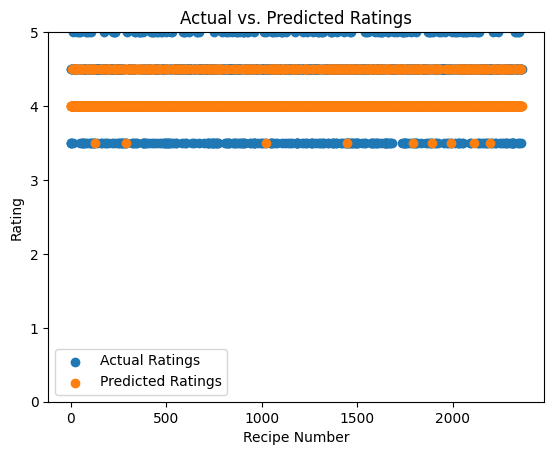

(LinearRegression(),
 4668,
 4783,
 49.39159877261665,
 1155,
 1208,
 48.87854422344478)

In [48]:
predict_rating_linear(df)

As we can see we got a prediction of 48.87.
Those results werent looking that great. We will try to use different machine learning algorthims in order to improve our prediction. The next algorithms we will try to use is KNN. Lets quickly create a new fucntion and run it:

In [49]:
def predict_rating_knn(df):

    
    # Prepare X and y
    X = df.drop(['Ingredients', 'Name', 'Rating'], axis=1)
    y = df['Rating']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create and fit the model
    best_k = 0
    best_accuracy = 0
    accuracies = []
    for k in range(1, 31):
        model = KNeighborsRegressor(n_neighbors=k)
        model.fit(X_train, y_train)
    
        # Make predictions on the training set
        y_train_pred = model.predict(X_train)
        y_train_pred_rounded = np.round(np.clip(y_train_pred, 0, 5) * 2) / 2
    
        # Count correct and incorrect predictions in the training set
        num_train_correct = np.sum(np.abs(y_train_pred_rounded - y_train) <= 0.25)
        percent_train_correct = num_train_correct / len(y_train) * 100
    
        # Make predictions on the testing set
        y_test_pred = model.predict(X_test)
        y_test_pred_rounded = np.round(np.clip(y_test_pred, 0, 5) * 2) / 2
    
        # Count correct and incorrect predictions in the testing set
        num_test_correct = np.sum(np.abs(y_test_pred_rounded - y_test) <= 0.25)
        percent_test_correct = num_test_correct / len(y_test) * 100
        
        # Print results
        print(f"For k={k}:")
        print(f"Number of correctly predicted recipes in the training set: {num_train_correct}")
        print(f"Percent of correctly predicted recipes in the training set: {percent_train_correct}%")
        print(f"Number of correctly predicted recipes in the testing set: {num_test_correct}")
        print(f"Percent of correctly predicted recipes in the testing set: {percent_test_correct}%")
        
        # Check if the current model is better than the previous best model
        if percent_test_correct > best_accuracy:
            best_k = k
            best_accuracy = percent_test_correct
        
        accuracies.append(percent_test_correct)

    print(f"\nBest k: {best_k}")
    print(f"Best percent of correctly predicted recipes in the testing set: {best_accuracy}%")
    
    # Plot the accuracy for each K value
    k_values = range(1, 31)
    plt.plot(k_values, accuracies, marker='o')
    plt.title("Accuracy vs. K Value")
    plt.xlabel("K Value")
    plt.ylabel("Accuracy (%)")
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()

    # Train the best model
    model = KNeighborsRegressor(n_neighbors=best_k)
    model.fit(X_train, y_train)
    
    # Make predictions on the testing set
    y_test_pred = model.predict(X_test)
    y_test_pred_rounded = np.round(np.clip(y_test_pred, 0, 5) * 2) / 2
    
    # Count correct and incorrect predictions in the testing set
    num_test_correct = np.sum(np.abs(y_test_pred_rounded - y_test) <= 0.25)
    num_test_incorrect = len(y_test) - num_test_correct
    percent_test_correct = num_test_correct / len(y_test) * 100
    
    # Print final results
    print("\nFinal results:")
    print(f"Number of recipes in the dataset: {len(df)}")
    print(f"Number of recipes in the training set: {len(X_train)}")

For k=1:
Number of correctly predicted recipes in the training set: 9451
Percent of correctly predicted recipes in the training set: 100.0%
Number of correctly predicted recipes in the testing set: 983
Percent of correctly predicted recipes in the testing set: 41.599661447312734%
For k=2:
Number of correctly predicted recipes in the training set: 6002
Percent of correctly predicted recipes in the training set: 63.50650724791027%
Number of correctly predicted recipes in the testing set: 1092
Percent of correctly predicted recipes in the testing set: 46.21244181125688%
For k=3:
Number of correctly predicted recipes in the training set: 5686
Percent of correctly predicted recipes in the training set: 60.162945720029626%
Number of correctly predicted recipes in the testing set: 1068
Percent of correctly predicted recipes in the testing set: 45.19678374947101%
For k=4:
Number of correctly predicted recipes in the training set: 5215
Percent of correctly predicted recipes in the training set:

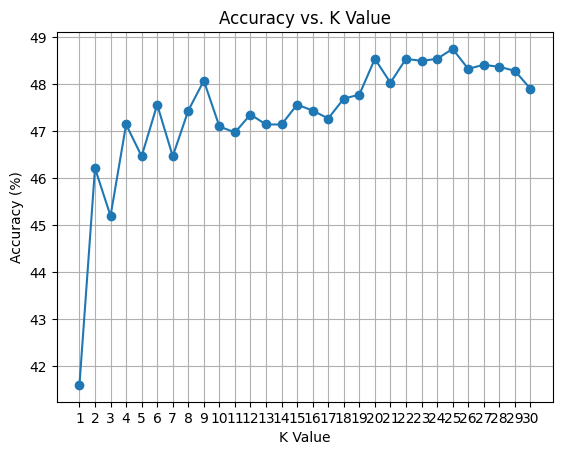


Final results:
Number of recipes in the dataset: 11814
Number of recipes in the training set: 9451


In [50]:
predict_rating_knn(df)

As we can see we got a correct prediction percentage of 48.75% with a K of 25 as best.

This didnt provide us with any better results. As last resort we will try to implement a Nural-Network model to possibly achieve a better result.

In [91]:
def predict_rating_mlp_root_mean_square_error(df):

    #as we dont understand how this works all that well so we followed renerall recommendations
    print("Preprocessing data...")
    # select features and target variable
    X = df.drop(['Ingredients', 'Name', 'Rating'], axis=1)
    y = df['Rating']

    # scale data
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    X_scraped = scaler.transform(df.drop(['Ingredients', 'Rating', 'Name'], axis=1))
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # build model
    print("Building model...")
    model = keras.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1))

    # compile model
    model.compile(loss='mse', optimizer='adam')

    # fit model
    model.fit(X_train, y_train, epochs=50, verbose=0)

    # Evaluate the model
    mse = model.evaluate(X_test, y_test, verbose=0)
    rmse = np.sqrt(mse)
    print(f'Root Mean Squared Error: {rmse:.3f}')

    # Predict the ratings for the scraped data
    y_pred = model.predict(X_scraped)

    # Round the predicted ratings to the nearest 0.5
    y_pred_rounded = np.round(y_pred * 2) / 2

    # Print the predicted ratings and their accuracy compared to the actual ratings
    print('Predicted Ratings:')
    print(y_pred_rounded.flatten())
    accuracy = r2_score(y_test, model.predict(X_test))
    print(f'R-squared (Accuracy) compared to test data: {accuracy:.3f}')

    # Visualize the results

    # Scatter plot of predicted ratings vs. actual ratings for test data
    plt.scatter(y_test, model.predict(X_test), color='b', label='Actual vs. Predicted (Test Data)')
    plt.plot([0, 5], [0, 5], color='r', linestyle='--')
    plt.title('Predicted Ratings vs. Actual Ratings (Test Data)')
    plt.xlabel('Actual Ratings')
    plt.ylabel('Predicted Ratings')
    plt.legend()
    plt.show()

    # Scatter plot of predicted ratings for scraped data
    plt.scatter(range(len(df)), y_pred_rounded.flatten(), color='g', label='Predicted (Scraped Data)')
    plt.title('Predicted Ratings for Scraped Data')
    plt.xlabel('Sample Index')
    plt.ylabel('Predicted Ratings')
    plt.legend()
    plt.show()

    return y_pred_rounded.flatten()

Preprocessing data...
Building model...
Root Mean Squared Error: 0.387
370/370 [==============================] - 1s 1ms/step
Predicted Ratings:
[5.  4.5 4.5 ... 4.  4.  4. ]
74/74 [==============================] - 0s 2ms/step
R-squared (Accuracy) compared to test data: -0.092
74/74 [==============================] - 0s 2ms/step


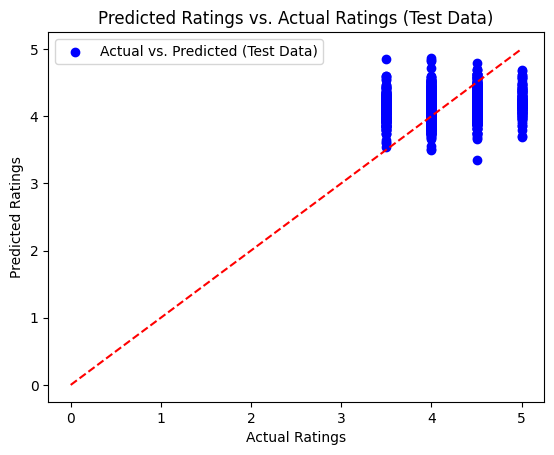

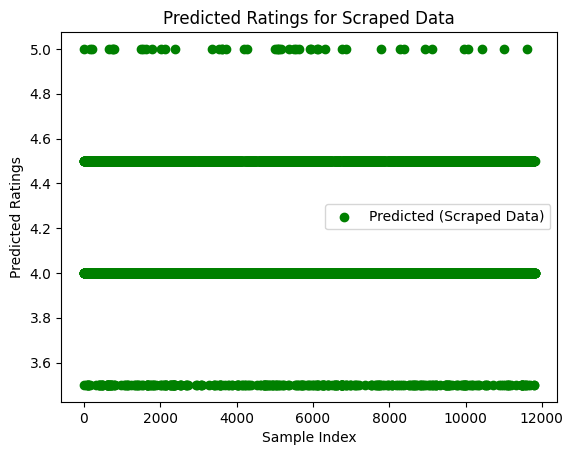

array([5. , 4.5, 4.5, ..., 4. , 4. , 4. ], dtype=float32)

In [93]:
predict_rating_mlp_root_mean_square_error(df)

The negative R-squared value suggests that the model is not a good fit for the data, and its predictions are worse than the mean prediction.


In summary, while the RMSE value of 0.388 suggests relatively good accuracy in terms of the average prediction error, the negative R-squared value of -0.092 indicates that the model's predictions are not accurate and are worse than using the mean of the dependent variable. This suggests that the model may need improvement or a different approach to better capture the patterns and relationships in the data.

#### Change of Plans - Future Engineering ####

Our accuracy hovers around 0.48 which isn't that good so we decided to scrape additional information as well as play around with feature engineering to try and improve our predictions. First we will try to scrape new data from our site that being the amount of steps needed to complete a recipe named 'Steps' and the number of ingredients needed for the recipe named 'Num_ing'. 

We decide to also make a popularity column that would sum the frequncy of each ingridient in the recepie to indicate "how unique" a recepie is(the higher the value the more common the ingridients),In addition we decided to make a difficulty column that takes into account both the steps, cooking time and number of ingredients to better detrmine how each recipe differes from one another.

This means we will need to change our scraping functions and to run the cleannnig functions on our new data as well :)

In [53]:
def get_steps_to_cook(soup_obj):
    class_name = "comp mntl-sc-block-group--LI mntl-sc-block mntl-sc-block-startgroup"
    elements = soup_obj.find_all(class_=class_name)
    return len(elements)

In [54]:
def merge_fast(url,recepie_name):
    df = pd.DataFrame(columns=['Name','Prep', 'Cook', 'Total', 'Servings', 'Rating','Rating_Count','Dairy','Meat','Fur', 'Calories', 'Fat', 'Carbs', 'Protein','Num_ing','Steps', 'Ingredients'])

    soup_obj = load_soup_object(url)
    
    if soup_obj is not None:
        recipe_df = get_cook_times(soup_obj)

        ratings_list= get_stars(soup_obj)

        nutrition_df = get_nutritional_values(soup_obj)

        ingredients = get_ingridients(soup_obj)

        rating_num = get_rating_count(soup_obj)

        meatdaity_df = analyze_recipe(ingredients)

        num_ing = len(ingredients)

        steps = get_steps_to_cook(soup_obj)

        if(ingredients==[]):
            ingredients=['','','','']
            print(type(nutrition_df['Calories'][0]))
        new_row = {
            'Name':recepie_name,
            'Prep': recipe_df['Prep'][0],
            'Cook': recipe_df['Cook'][0],
            'Total': recipe_df['Total'][0],
            'Servings': recipe_df['Servings'][0],
            'Rating': ratings_list,
            'Rating_Count':rating_num,
            'Dairy':meatdaity_df['Dairy'][0],
            'Meat':meatdaity_df['Meat'][0],
            'Fur':meatdaity_df['Fur'][0],
            'Calories': nutrition_df['Calories'][0],
            'Fat': nutrition_df['Fat'][0],
            'Carbs': nutrition_df['Carbs'][0],        
            'Protein': nutrition_df['Protein'][0],
            'Num_ing' : num_ing,
            'Steps' : steps,      
            'Ingredients': [ingredients]
        }
        #print(new_row)

        # add the new row to the DataFrame
        df = pd.concat([df, pd.DataFrame(new_row)], ignore_index=True)
        #df_concat = pd.concat([df1, df2], keys=['df2'])
        df['Prep'] = df['Prep'].astype(float)
        df['Cook'] = df['Cook'].astype(float)
        df['Total'] = df['Total'].astype(float)
        df['Servings'] = df['Servings'].astype(float)
        df['Rating'] = df['Rating'    ].astype(float)
        df['Calories'] = df['Calories'].astype(float)

        # display the updated DataFrame
        #print("another line added")
    return(df)

Now we have to run the scraping all over again, as well as to clean the initial data as we did. Its a long process but nothing can be done about it...

In [57]:
fast_scrape('Recipe_Links_and_Names.csv')
Updated_Data = pd.read_csv('my_data.csv')
Updated_Data['Fat'] = Updated_Data['Fat'].str.replace(',', '').str.strip().str.rstrip('g').astype(int)
Updated_Data['Carbs'] = Updated_Data['Carbs'].str.replace(',', '').str.strip().str.rstrip('g').astype(int)
Updated_Data['Protein'] = Updated_Data['Protein'].str.replace(',', '').str.strip().str.rstrip('g').astype(int)
Updated_Data = clean_data_time(Updated_Data)
Updated_Data = clean_df(Updated_Data)
Updated_Data = remove_teaspoon(Updated_Data,'Ingredients')
Updated_Data = clean_ingridients(Updated_Data)


print("DONE!")

count    13044.000000
mean        28.066391
std        248.610160
min          0.000000
25%         10.000000
50%         15.000000
75%         20.000000
max      20170.000000
Name: Prep, dtype: float64
count    12856.000000
mean        16.498989
std         14.916378
min          0.000000
25%         10.000000
50%         15.000000
75%         20.000000
max        120.000000
Name: Prep, dtype: float64
count    12856.000000
mean       208.694384
std       1881.980945
min          0.000000
25%         10.000000
50%         30.000000
75%         70.000000
max      57610.000000
Name: Cook, dtype: float64
count    12487.000000
mean        65.406503
std        109.399120
min          0.000000
25%         10.000000
50%         25.000000
75%         60.000000
max        670.000000
Name: Cook, dtype: float64
count    12487.000000
mean        81.774325
std        112.069010
min          0.000000
25%         21.000000
50%         44.000000
75%         85.000000
max        720.000000
Name: Total,

In [74]:
def add_popularity_score_to_df(df):
    binary_columns = [col for col in df.columns if col not in ['Name', 'Prep', 'Cook', 'Total', 'Servings', 'Rating', 'Rating_Count', 'Dairy', 'Meat', 'Fur', 'Calories', 'Fat', 'Carbs', 'Protein', 'Num_ing', 'Steps', 'Ingredients','Difficulty','Z_score','Combined']]

    # Calculate the frequencies of each binary value
    ingredient_frequencies = df[binary_columns].sum() / len(df) * 30

    # Calculate the popularity score for each recipe
    popularity_scores = []
    for _, row in df.iterrows():
        score = 0
        for column in binary_columns:
            if row[column] == 1:
                score += ingredient_frequencies[column]
        popularity_scores.append(score)

    # Add the popularity scores as a new column to the DataFrame
    df['Popularity Score'] = popularity_scores

    # Print the updated DataFrame
    #print(df)
    #scraping_functions.draw_histo_1_params(df,'Popularity Score')
    return df

In [75]:
def add_difficulty_column(df):
    # Calculate the combined score for each recipe
    df['Combined'] = df['Num_ing'] + df['Steps'] + df['Total']
    
    # Calculate the mean and standard deviation of the combined score
    mean = df['Combined'].mean()
    std_dev = df['Combined'].std()
    
    # Calculate the z-score for each recipe
    df['Z_score'] = (df['Combined'] - mean) / std_dev
    
    # Divide the z-scores into 5 equal-sized groups
    df['Difficulty'] = pd.qcut(df['Z_score'], q=5, labels=[1, 2, 3, 4, 5])
    
    
    # Print the number of recipes in each difficulty level
    for i in range(1, 6):
        count = df['Difficulty'][df['Difficulty'] == i].count()
        print(f"Difficulty level {i}: {count}")
    
    return df

In [94]:
Updated_Data = add_difficulty_column(Updated_Data)
Updated_Data = explode_ingridients_and_get_corr(Updated_Data)
Updated_Data = add_popularity_score_to_df(Updated_Data)


Difficulty level 1: 2461
Difficulty level 2: 2369
Difficulty level 3: 2407
Difficulty level 4: 2390
Difficulty level 5: 2404
Top 20 ingredients with the highest correlation with the 'Rating' column:
liqueur       0.062018
juice         0.057409
vodka         0.045100
olive         0.044073
orange        0.038635
apple         0.034252
cheese        0.030138
bacon         0.029886
lemon         0.029311
mayonnaise    0.025067
mayonnais     0.025067
pepper        0.024460
sage          0.023938
pecan         0.023641
walnut        0.023567
pineapple     0.023218
pear          0.023155
beer          0.022823
sour cream    0.021995
cabbage       0.021867
Name: Rating, dtype: float64


Lets save the newly accuried data!

In [10]:
def save_df(df,name):
    df.to_csv(name, index=True, encoding='utf-8')

save_df(Updated_Data, 'FinalCSVFile.csv')

Lets check the Number of ingredients per recipe with our plot function

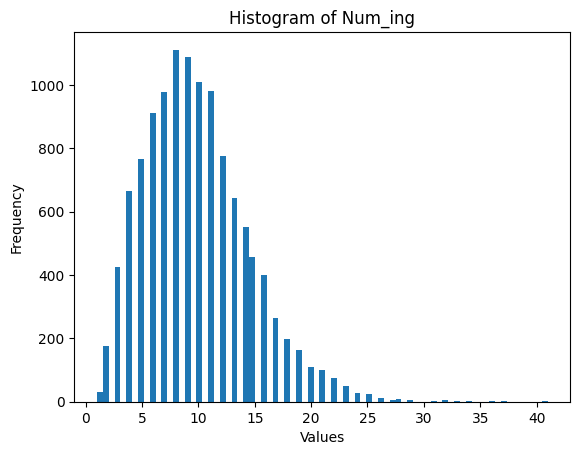

In [79]:
draw_histo_1_params(Updated_Data,'Num_ing')

Analyzing the histogram of the number of ingredients, we observe a normal distribution pattern. The average recipe contains around 10 ingredients. The majority of recipes fall within the range of 3 to 25 ingredients, indicating that most recipes can be prepared with a moderate number of ingredients. However, there are a few outliers with more than 27 ingredients, suggesting that some recipes may be more complex and require a wider variety of components.

Lets see if anything new appearded in regards to the correlation.


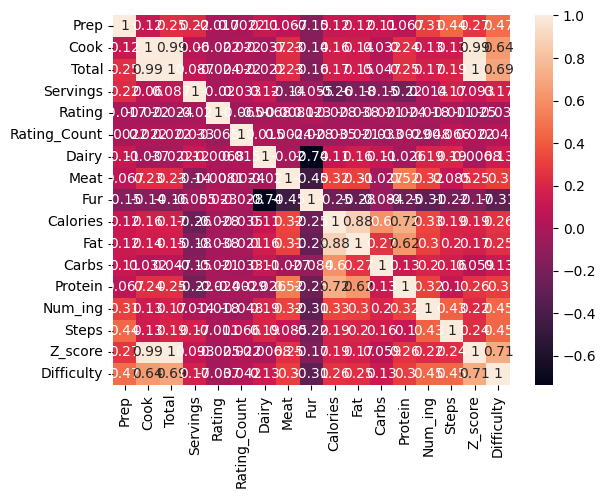

Correlations above 0.5 or below -0.5:
Total - Cook: 0.9915329069544503
Fur - Dairy: -0.7371208270796086
Fat - Calories: 0.8783941519096898
Carbs - Calories: 0.5998221772474607
Protein - Meat: 0.5242292713828088
Protein - Calories: 0.7239240460231868
Protein - Fat: 0.6204029532431966
Z_score - Cook: 0.9862231766023424
Z_score - Total: 0.9980277545810404
Difficulty - Cook: 0.63968606000679
Difficulty - Total: 0.6860034596455415
Difficulty - Z_score: 0.7092970986620543


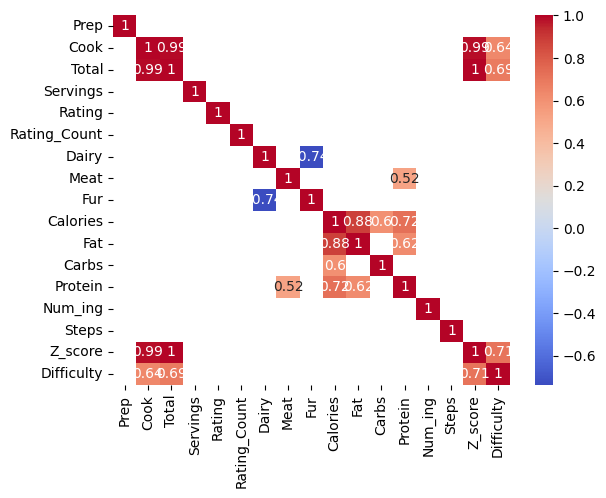

In [80]:
def draw_heatmap_view(df):
    heat_map_view = df[['Prep', 'Cook', 'Total', 'Servings', 'Rating', 'Rating_Count', 'Dairy', 'Meat', 'Fur', 'Calories','Fat','Carbs','Protein','Num_ing','Steps','Z_score','Difficulty']]
    sns.heatmap(heat_map_view.corr(), annot=True)
    plt.show()

def draw_heatmap_view_important(df):
    heat_map_view = df[['Prep', 'Cook', 'Total', 'Servings', 'Rating', 'Rating_Count', 'Dairy', 'Meat', 'Fur', 'Calories','Fat','Carbs','Protein','Num_ing','Steps','Z_score','Difficulty']]
    corr = heat_map_view.corr()
    mask = (corr > 0.5) | (corr < -0.5)  # set the threshold for correlation values
    sns.heatmap(corr, annot=True, mask=~mask, cmap='coolwarm')
    
    # print the correlations above 0.5 or below -0.5
    print("Correlations above 0.5 or below -0.5:")
    for i in range(len(corr.columns)):
        for j in range(i):
            if mask.iloc[i, j]:
                print(f"{corr.index[i]} - {corr.columns[j]}: {corr.iloc[i, j]}")

    plt.show()


draw_heatmap_view(Updated_Data)
draw_heatmap_view_important(Updated_Data)

As we can see nothing outstanding really appeared from the extra scraping and feature enginering but lets see if our algorithm can be improved with this new data and features.

Number of recipes in the dataset: 12031
Number of recipes in the training set: 9624
Number of recipes in the testing set: 2407
Number of correctly predicted recipes in the testing set: 1155
Number of incorrectly predicted recipes in the testing set: 1252
Percent of correctly predicted recipes in the testing set: 47.98504362276693%


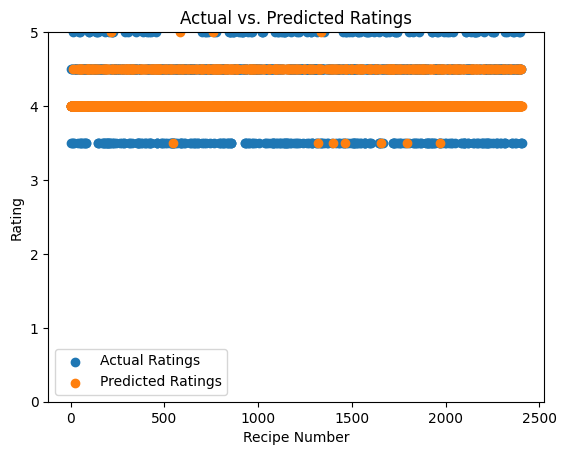

(LinearRegression(),
 4774,
 4850,
 49.60515378221114,
 1155,
 1252,
 47.98504362276693)

In [81]:
predict_rating_linear(Updated_Data)

For k=1:
Number of correctly predicted recipes in the training set: 9624
Percent of correctly predicted recipes in the training set: 100.0%
Number of correctly predicted recipes in the testing set: 955
Percent of correctly predicted recipes in the testing set: 39.675945159950146%
For k=2:
Number of correctly predicted recipes in the training set: 6084
Percent of correctly predicted recipes in the training set: 63.21695760598504%
Number of correctly predicted recipes in the testing set: 1067
Percent of correctly predicted recipes in the testing set: 44.32904029912754%
For k=3:
Number of correctly predicted recipes in the training set: 5848
Percent of correctly predicted recipes in the training set: 60.76475477971738%
Number of correctly predicted recipes in the testing set: 1080
Percent of correctly predicted recipes in the testing set: 44.869131699210634%
For k=4:
Number of correctly predicted recipes in the training set: 5361
Percent of correctly predicted recipes in the training set:

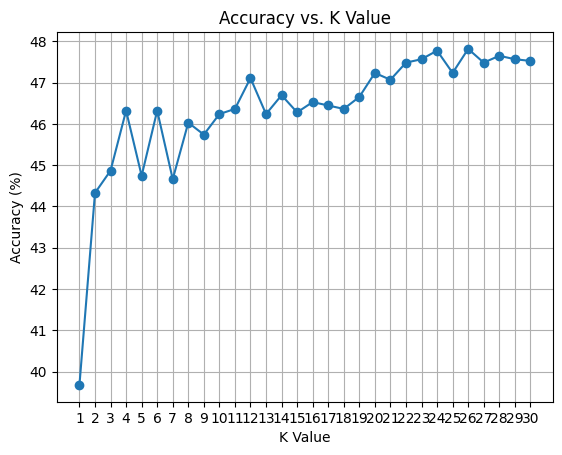


Final results:
Number of recipes in the dataset: 12031
Number of recipes in the training set: 9624


In [82]:
predict_rating_knn(Updated_Data)

Preprocessing data...
Building model...
Root Mean Squared Error: 0.399
376/376 [==============================] - 0s 1ms/step
Predicted Ratings:
[4.5 4.5 4.5 ... 4.  4.  4. ]
76/76 [==============================] - 0s 1ms/step
R-squared (Accuracy) compared to test data: -0.174
76/76 [==============================] - 0s 1ms/step


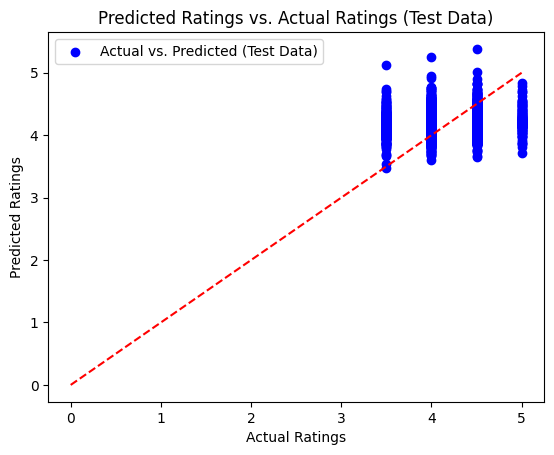

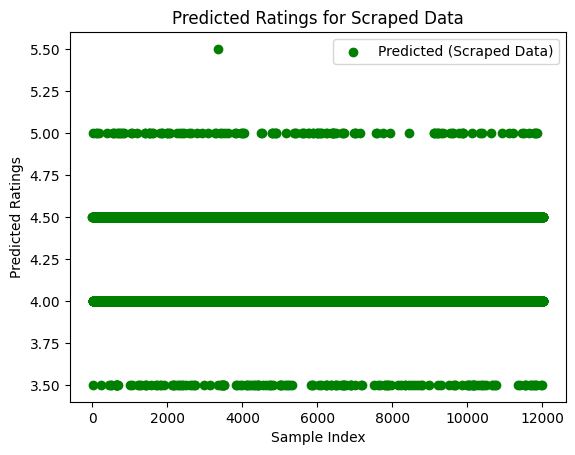

array([4.5, 4.5, 4.5, ..., 4. , 4. , 4. ], dtype=float32)

In [83]:
predict_rating_mlp_root_mean_square_error(Updated_Data)

Surprisingly, even after implementing fancy feature engineering techniques and throwing in loads of additional data into the mix, our models couldn't seem to get their act together and improve the accuracy. In fact, the latest attempt turned out to be a total flop, with an even lower score than before. 
We experimented left and right with different ways to extract more useful info from the data. We went through each feature with a fine-toothed comb, ditching anything that didn't make a noticeable difference. But no matter what we did, our models just couldn't crack the code and deliver the accuracy we were hoping for. It's clear as day that we need to come up with a whole new game plan to tackle this problem.

#### Changing our Approach ####

After realizing our previous attempts to predict star ratings were not yielding satisfactory results, we decided to take a different approach. Instead of directly predicting star ratings, we focused on a simpler question: Can we determine if a recipe is "good" or not? We defined "good" as recipes with a 5-star rating. To answer this question, we used a Perceptron model, a binary classification model.which will  determine if a recipe is 5 stars or not. if the model was relatively successful we wanted to look at the weights of the model to get an indication for what are the contibuting factors and what are the hindering factors.

We acknowledge that there is an ongoing debate about what constitutes a "good" recipe, but we chose to focus on the highest rating of 5 stars(as they are arguably the best). Our goal was to uncover patterns and insights that distinguish these exceptional recipes. Through the Perceptron model, we aimed to discover the key factors that contribute to a recipe's top rating so it could be used to develop new recipes with a higher likelihood of achieving the coveted 5-star status.

While our initial attempts to predict star ratings fell short, we remain hopeful that this new approach will shed light on the secrets of highly rated recipes. By analyzing the factors that set apart 5-star recipes, we aim to gain a deeper understanding of what makes a recipe truly outstanding. Let's delve into the Perceptron model and explore the world of exceptional recipes!

In [15]:

def build_perceptron_model(df):
    #df = pd.read_csv('test123.csv')

    # Save the 'Rating' column separately
    ratings = df['Rating']
    
    # Drop the 'Rating' column from the dataframe
    df = df.drop(['Rating'], axis=1)
    df = df.drop(['Rating_Count'], axis=1)
    df = df.select_dtypes(include=['int', 'float'])
    # Get the column names of the dataframe
    col_names = df.columns

    # Convert the dataframe to a numpy array
    X = df.select_dtypes(include=['int', 'float']).values

    # Define the target variable
    y = (ratings == 5).astype(int).values
    
    # Verify that X and y have the same length
    assert len(X) == len(y), "X and y must have the same length"

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

    # Fit the Perceptron model to the training data
    model = Perceptron()
    model.fit(X_train, y_train)

    # Compute the predictions on the test data
    y_pred = model.predict(X_test)

    # Compute the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Get the weights learned by the perceptron
    weights = model.coef_[0]

    # Create a new dataframe with the column names and weights
    weights_df = pd.DataFrame({'column': col_names, 'weight': weights})

    # Print the weights dataframe
    print(weights_df)

    #save_df(weights_df,'FML.csv')
    return weights_df

In [16]:

weights_data = build_perceptron_model(Updated_Data)

Accuracy: 0.95
               column       weight
0          Unnamed: 0 -8013.000000
1                Prep -3264.000000
2                Cook -2521.000000
3               Total -5785.000000
4            Servings -4315.000000
..                ...          ...
237               egg  -201.000000
238               rye   -31.000000
239               nut    50.000000
240               tea    72.000000
241  Popularity Score -6512.817721

[242 rows x 2 columns]


We were thrilled with the remarkable result we achieved using the Perceptron model: an impressive accuracy score of 0.95. It seemed almost too good to be true, so we decided to put it to the test again with a different random state. We wanted to ensure that the model's performance was consistent and not influenced by any random variations. Despite changing the random state, the model continued to deliver exceptional results, further reinforcing our confidence in its ability to identify exceptional recipes. 

In [19]:
sorted_df = weights_data.sort_values(by='weight')
save_df(sorted_df,'weights.csv')
# printing the top 10 rows
print(sorted_df.tail(15)[['column', 'weight']])

# printing the bottom 10 rows
print(sorted_df.head(15)[['column', 'weight']])

        column  weight
92   pineapple   129.0
147     almond   129.0
127    vanilla   145.0
110   cinnamon   152.0
207      olive   183.0
224       lime   204.0
152     orange   218.0
204      vodka   218.0
135    liqueur   239.0
200      apple   311.0
197      juice   524.0
7          Fur   596.0
13       Steps  1656.0
12     Num_ing  2380.0
10       Carbs  8242.0
               column       weight
9                 Fat -9089.000000
11            Protein -8367.000000
0          Unnamed: 0 -8013.000000
241  Popularity Score -6512.817721
3               Total -5785.000000
4            Servings -4315.000000
1                Prep -3264.000000
2                Cook -2521.000000
14           Combined -1749.000000
8            Calories -1428.000000
206             onion  -410.000000
15            Z_score  -402.488185
209             flour  -320.000000
158            garlic  -232.000000
237               egg  -201.000000


Based on the weights obtained from our model, we identified the top factors that contribute the most to a recipe being rated as 5 stars. These factors include:
Num_ing,Steps,Carbs

These variables had the highest weights in our weights dataframe, indicating their significant influence on the rating. Conversely, we also identified the worst features, which included:
popularity score, prep, cook, total time, servings, protein and fat.

These factors had negative weights, suggesting that recipes with longer preparation and cooking times, larger servings and higher in protein and fat, are less likely to receive a 5-star rating.

These findings provide valuable insights into the preferences of users when it comes to recipe ratings. Recipes with shorter cooking times, lower servings (indicating higher carbs per serving), and unique ingredients tend to have a higher likelihood of receiving a 5-star rating. Additionally, the negative weight associated with popularity score suggests that recipes with lower popularity scores may be more likely to receive higher ratings. This supports our hypothesis that incorporating rare ingredients (such as caviar or lobster as an example) could potentially improve the chances of a recipe being rated highly. Overall, these findings open up new possibilities for creating recipes that align with user preferences and have a higher probability of receiving favorable ratings.

to conclude : 
1. What factors contribute to the popularity of a recipe, and how accurately can we predict a recipe's popularity based on these factors?

As we saw by using the preceptrons weights as we did, we managed to figure out what are the factors that contribute the most to our recepie which were:
Num_ing,Steps,Carbs.

It is important to note that using only those paramets will likely yied a lower prediction rate but these are the main features it is also recommended to avoid the following factors(High numbers):
Commonly used ingredients, prep, cook, total time, servings, protein and fat.

2. Is it possible to determine if a recipe will receive a high rating?

Yes, with a high degree of accuracy(0.95 in our case) given enough data about the recepie :)

#### Data Sources ####

Stack Overflow - https://stackoverflow.com/

Google Scholar - https://scholar.google.com/

Pandas Documentary - https://pandas.pydata.org/docs/

Keras Documentary - https://keras.io/guides/

Selenium Documentary - https://www.selenium.dev/selenium/docs/api/py/api.html

Perceptron Wikipedia - https://en.wikipedia.org/wiki/Perceptron

Nural Networks Wikipedia - https://en.wikipedia.org/wiki/Neural_network

ChatGPT - https://chat.openai.com/

Bard - https://bard.google.com/